# Schulich MBAN Analytics Consulting Project
# Client - Interac Corp.
![image info](Schulich_Logo.jpeg)
![image info](Interac-Logo.png)


# Packages

In [4]:
# import necessary packages
import pandas as pd
import numpy as np
import mysql.connector
from mysql.connector import Error
from sqlalchemy import create_engine
import pymysql
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
import shap
import pickle
%matplotlib inline


# Data Access

### 

In [2]:
pw = 'Jose@1992'

### MySql Connection

In [3]:
# MySql Local connection
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='ACP',
                                         user='root',
                                         password=pw)
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)
# finally:
#     if connection.is_connected():
#         cursor.close()
#         connection.close()
#         print("MySQL connection is closed")

Connected to MySQL Server version  8.0.28
You're connected to database:  ('acp',)


In [4]:
# import base64
# import setting 

# input_url = setting.onedrive_url

# def create_onedrive_directdownload (onedrive_link):
#     data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
#     data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
#     resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
#     print(f"Direct OneDrive Download Link : {resultUrl}")
#     return resultUrl

# one_drive_link = create_onedrive_directdownload(input_url)

In [6]:
# read training and testing dataframes from sql query
# data = pd.read_sql("select * from ACP.interacdashboard2020",connection)
# test = pd.read_sql("select * from ACP.interacdashboardfinalv2",connection)
data = pd.read_csv('/Users/xingkaiwu/Desktop/ACP/interac_dashboard.csv',low_memory=False)
test = pd.read_csv('/Users/xingkaiwu/Desktop/ACP/InteracDashboardFinalv2.csv',low_memory=False)

In [3]:
for col in data:
    print(col," : ",data[col].unique())
    print('\n')

pk  :  [     1      2      3 ... 298085 298086 298087]


rid  :  ['EPOQFBNHCQ9XTGT4D3' 'EPOQVJW297VZK3W4D3' 'EPOQDJ7P4LNCR3K4D4' ...
 'xrnvr8xp8psrysj4' 'pvrdnfd8frd8t7d5' 'zzse75dtem4yfrhq']


trans_date  :  ['10/21/2016' '11/4/2016' '10/28/2016' '10/27/2016' '10/19/2016'
 '10/20/2016' '10/29/2016' '11/3/2016' '10/25/2016' '10/22/2016'
 '10/24/2016' '10/26/2016' '10/30/2016' '11/6/2016' '10/31/2016'
 '11/2/2016' '11/7/2016' '10/23/2016' '11/1/2016' '11/8/2016' '11/10/2016'
 '11/5/2016' '11/9/2016' '11/15/2017' '11/16/2017' '11/17/2017'
 '11/18/2017' '11/20/2017' '11/12/2017' '11/11/2017' '11/13/2017'
 '11/14/2017' '11/7/2017' '11/9/2017' '11/10/2017' '11/8/2017' '11/4/2017'
 '11/5/2017' '11/6/2017' '11/3/2017' '11/2/2017' '11/19/2017' '11/21/2017'
 '11/1/2017' '11/1/2018' '11/2/2018' '11/3/2018' '11/4/2018' '11/5/2018'
 '11/6/2018' '11/7/2018' '11/8/2018' '11/9/2018' '11/10/2018' '11/11/2018'
 '11/12/2018' '11/13/2018' '11/14/2018' '11/15/2018' '11/16/2018'
 '11/17/2018' '11/18/2018' 

In [7]:
# Only year 2019 and 2020 will be considered due to the fact of COVID- 19
data = data[data['trans_year'].isin([2019,2020])==True]

In [8]:
data['user_income'].value_counts()

$60K - $99K    27124
$100k+         16477
$30k - $59k    12503
$100K+         10196
<$30k           9029
$30K - $59K     8837
Name: user_income, dtype: int64

In [9]:
data.isna().sum()

pk                                     0
rid                                    0
trans_date                             0
trans_date_formatted                   0
trans_year                             0
trans_dow                              0
trans_time                             0
trans_amount                           0
trans_main_category                    0
trans_sub_category                     0
trans_brand                            0
trans_card_swipe_method            26441
trans_card_swipe_method_type       26649
trans_payment_type                     0
trans_payment_method                   0
trans_inperson_place_type          18625
trans_inperson_place_name          11100
trans_inperson_purchase_address    18561
trans_online_url                   80831
trans_online_web                   83064
trans_other_description            85402
trans_lp_redeemed                  14386
trans_lp_type_collected             9468
trans_no_purhcase_confirm          86109
trans_interac_se

# Data Transformation

### Demographic Variables

In [17]:
data.columns

Index(['pk', 'rid', 'trans_date', 'trans_date_formatted', 'trans_year',
       'trans_dow', 'trans_time', 'trans_amount', 'trans_main_category',
       'trans_sub_category', 'trans_brand', 'trans_card_swipe_method',
       'trans_card_swipe_method_type', 'trans_payment_type',
       'trans_payment_method', 'trans_inperson_place_type',
       'trans_inperson_place_name', 'trans_inperson_purchase_address',
       'trans_online_url', 'trans_online_web', 'trans_other_description',
       'trans_lp_redeemed', 'trans_lp_type_collected',
       'trans_no_purhcase_confirm', 'trans_interac_segments',
       'trans_dig_segments', 'trans_flash', 'user_weight',
       'user_weekly_factor', 'user_age', 'user_income', 'user_salary',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_visible_minority',
       'user_smartphone_usage', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'u

In [18]:
data['trans_payment_type'].value_counts()

In Person    79050
Online        6352
Other          707
Name: trans_payment_type, dtype: int64

#### Missing data imputation

In [10]:
# Imputer user_income, trans_lp_type_collected, here
data['trans_lp_type_collected'] = data['trans_lp_type_collected'].fillna('NA')
data['user_income'] = data['user_income'].fillna('<$30k')

In [11]:
data['trans_lp_type_collected'] = data['trans_lp_type_collected'].replace(
                                {
                                "Other":1,
                                "SeparateCard":1,
                                "PaymentCard":1,
                                "Both":1,
                                "NA":0
                                })

In [12]:
# count number of online/ in-person and other transaction
data1 = pd.get_dummies(data,columns = ['trans_payment_type'])
data1['num_online'] = data1.groupby(['rid']).trans_payment_type_Online.transform(np.sum)
data1['num_inperson'] = data1.groupby(['rid'])['trans_payment_type_In Person'].transform(np.sum)
data1['num_other'] = data1.groupby(['rid']).trans_payment_type_Other.transform(np.sum)
data1['num_lp'] = data1.groupby(['rid']).trans_lp_type_collected.transform(np.sum)

In [13]:
# binary variables, replacing with 1s and 0s
data1['user_visible_minority'] = data1['user_visible_minority'].replace(
                                {
                                "Not Visible Minority":0,
                                "Visible Minority":1
                                })

data1['user_smartphone_usage'] = data1['user_smartphone_usage'].replace(
                                {
                                "Non-Smartphone Users":0,
                                "Smartphone Users":1
                                })

data1['user_debit_tap_availability'] = data1['user_debit_tap_availability'].replace(
                                {
                                "Tap Not Available":0,
                                "Tap Available":1
                                })

#### Getting dummy variables for categorical variables

In [30]:
# columns = ['user_age', 'user_income',
#        'user_gender', 'user_region', 'user_education', 'user_lifestage',
#        'user_immigrant_status', 'user_payment_preference',
#        'user_banking_package', 'user_main_bank', 'user_main_debit_card',
#        'user_main_credit_card']

# data1 = pd.get_dummies(data1,columns = columns)

In [14]:
# rename data classes in trans_payment_method_agg and trans_main_category_agg
data1['trans_payment_method_agg']=data1['trans_payment_method'].replace(
                                    {
                                    "Mastercard Credit":"credit",
                                    "Visa Credit":"credit",
                                    "Reloadable/Pre-Paid":"credit",
                                    "Amex Credit":"credit",
                                    "Other Credit":"credit"
                                    })

data1['trans_main_category_agg']=data1['trans_main_category'].replace(
                                    {
                                    "Grocery/Drug/Department/Warehouse Store":"grocery",
                                    "Restaurant/Bar/Coffee shop":"restaurant",
                                    "Convenience Store/Gas Station":"travel",
                                    "Transit/Travel/Parking":"travel",
                                    "Hardware/Home Improvement/Auto":"home",
                                    "Home Furnishing, Appliance, Decor, Home Office":"home",
                                    "Clothing/Jewellery/Shoes/Sporting Goods":"personal",
                                    "Electronics/Books/Music/Entertainment/Toys":"personal",
                                    "Miscellaneous Goods and Services":"Miscellaneous",
                                    "Health/Beauty/Drug Store":"Miscellaneous",
                                    "Other":"Miscellaneous",
                                    "Beer/Wine/Liquor":"Liquor"
                                    })

# combine trans_payment_method_agg and trans_main_category_agg with /
data1['trans_category_and_payment'] = data1[["trans_main_category_agg","trans_payment_method_agg"]].agg('/'.join,axis=1)

# aggregate transaction amount by rid and trans_category_and_payment
data1['total_amount'] = data1.groupby(['rid','trans_category_and_payment']).trans_amount.transform(np.sum)
data1 = data1.sort_values(by=['rid','trans_category_and_payment'])



In [15]:
# get distinct values of the dataframe based on rid and trans_category_and_payment
data1 = data1.drop_duplicates(subset = ['rid','trans_category_and_payment'])

In [16]:
# pivot table will generate new columns for trans_category_and_payment in user level
data2 = data1.pivot_table('total_amount',['rid'],'trans_category_and_payment')

In [17]:
# fill pivot table null values with 0
data2 = data2.fillna(0)

In [18]:
data1.columns.values

array(['pk', 'rid', 'trans_date', 'trans_date_formatted', 'trans_year',
       'trans_dow', 'trans_time', 'trans_amount', 'trans_main_category',
       'trans_sub_category', 'trans_brand', 'trans_card_swipe_method',
       'trans_card_swipe_method_type', 'trans_payment_method',
       'trans_inperson_place_type', 'trans_inperson_place_name',
       'trans_inperson_purchase_address', 'trans_online_url',
       'trans_online_web', 'trans_other_description', 'trans_lp_redeemed',
       'trans_lp_type_collected', 'trans_no_purhcase_confirm',
       'trans_interac_segments', 'trans_dig_segments', 'trans_flash',
       'user_weight', 'user_weekly_factor', 'user_age', 'user_income',
       'user_salary', 'user_gender', 'user_region', 'user_education',
       'user_lifestage', 'user_immigrant_status', 'user_visible_minority',
       'user_smartphone_usage', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card', 'user_

In [19]:
data3 = data1[['rid', 'trans_lp_type_collected', 
       'user_weight', 'user_weekly_factor', 
       'user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability',
       'user_segment', 'num_online', 'num_inperson', 'num_other', 'num_lp',
       'user_age','user_income','user_gender',
       'user_region','user_education','user_lifestage',
       'user_immigrant_status','user_payment_preference',
       'user_banking_package', 'user_main_bank',
       'user_main_debit_card','user_main_credit_card']]

In [20]:
data3= data3.set_index('rid')

In [21]:
data3['rid']=data3.index

In [22]:
# get distinct values of the dataframe based on rid
data3 = data3.drop_duplicates(subset = ['rid'])

In [23]:
# combine user level data with pivot table
data_final = pd.concat([data2,data3],axis = 1)

In [24]:
data_final.isna().sum().sum()

0

In [25]:
data_final = data_final.iloc[:,:-1]

In [26]:
data_final.to_csv('final_data.csv')

In [27]:
data_final

,Liquor/Cash,Liquor/Interac,Liquor/Other,Liquor/credit,Miscellaneous/Cash,Miscellaneous/Interac,Miscellaneous/Other,Miscellaneous/credit,grocery/Cash,grocery/Interac,...,user_gender,user_region,user_education,user_lifestage,user_immigrant_status,user_payment_preference,user_banking_package,user_main_bank,user_main_debit_card,user_main_credit_card
rid,,,,,,,,,,,,,,,,,,,,,
0095e0ht90ftcf0r,0.0,0.00,0.0,0.0,0.0,0.0,0.0,30.27,0.00,0.00,...,Male,British Columbia,University/College,Couple with younger kids,Canadian Born,Credit,Limited,CIBC,CIBC,Visa Credit
00cq6qzr6d88r2g1,0.0,0.00,0.0,88.0,0.0,0.0,0.0,0.00,10.90,3.73,...,Male,Quebec,University/College,Empty nesters,Canadian Born,Mixed,Unlimited,Other,Other,Visa Credit
00gu96wutfpymjua,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,Male,Ontario,University/College,Couple with Older Kids,Canadian Born,Credit,DKNA,RBC,RBC,MasterCard Credit
00h1yh3y46k2t9e1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,39.00,0.00,0.00,...,Male,Alberta,Some University/College,Single no Kids,Canadian Born,Mixed,Unlimited,CIBC,PC/Simplii,MasterCard Credit
00mbm8equ6ce1rq7,0.0,0.00,0.0,57.5,0.0,0.0,0.0,0.00,0.00,0.00,...,Female,Ontario,University/College,Single no Kids,Canadian Born,Credit,Limited,Scotiabank,Scotiabank,Visa Credit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zz8cq8tuzvg0fsvr,0.0,126.64,0.0,0.0,0.0,0.0,0.0,0.00,6.58,258.74,...,Female,Man/Sask,High School or Less,Couple no Kids,Canadian Born,Debit,DKNA,RBC,RBC,MasterCard Credit
zzc04n7hmyw9vc8d,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,46.00,0.00,...,Female,Ontario,University/College,Single no Kids,Canadian Born,Mixed,Limited,TD,CIBC,MasterCard Credit
zzr23vw3xka94kbx,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,...,Female,British Columbia,High School or Less,Couple with younger kids,10 Years+ in Canada,Credit,DKNA,RBC,RBC,MasterCard Credit


# Modelling(with 'no segment')

In [43]:
data_final = pd.read_csv('final_data.csv')
X = data_final.copy().drop(columns=['user_segment','rid'])
y = data_final['user_segment']

In [38]:
y.value_counts()

No Segment            2721
The Achiever          2101
The Maximizer         1581
The On-the-Goer        910
The Collector          891
The Safekeeper         721
The Budgeter           673
The Traditionalist     451
Name: user_segment, dtype: int64

In [65]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

In [66]:
categorical_columns

['user_age',
 'user_income',
 'user_gender',
 'user_region',
 'user_education',
 'user_lifestage',
 'user_immigrant_status',
 'user_payment_preference',
 'user_banking_package',
 'user_main_bank',
 'user_main_debit_card',
 'user_main_credit_card']

In [102]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [110]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)

In [111]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_age', 'user_income',
                                                   'user_gender', 'user_region',
                                                   'user_education',
                                                   'user_lifestage',
                                                   'user_immigrant_status',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                     

## HistGradientBoostingClassifier

In [112]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['user_age',
                                                                          'user_income',
                                                                          'user_gender',
                                                                          'user_region',
                                                                          'user_educati

In [113]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}


In [114]:
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.65
The test accuracy score of the grid-searched pipeline is: 0.42


In [115]:
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))

0.3487748696607682

In [116]:
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))

Confusion Matrix (Accuracy 0.6478)

       Prediction
Actual    0    1    2    3    4    5    6    7
     0 1644  199   31   44   91   84   52   31
     1  234 1247    8   43  140    6    2    1
     2  147   24  273    9   12   26   26   21
     3  131  179   11  268  107    5    5    7
     4  236  357    4   70  589    5    2    2
     5   97   11    5    2    2  576   33    2
     6  123    7   14    5    5   73  345    5
     7   62    2   10    4    4    2   11  266
Confusion Matrix (Accuracy 0.4219)

       Prediction
Actual   0   1   2   3   4   5   6   7
     0 318  74  19  25  31  37  19  22
     1  85 255   0  13  62   4   0   1
     2  65   5  16   2   5  15   9  18
     3  37  54   2  32  48   0   1   4
     4  68 139   3  30  72   2   2   0
     5  46   4   6   0   5  94  27   0
     6  45   7   7   4   5  45  29   2
     7  29   0  19   4   2   0   4  32


In [117]:
y_test.value_counts()

No Segment            545
The Achiever          420
The Maximizer         316
The On-the-Goer       182
The Collector         178
The Safekeeper        144
The Budgeter          135
The Traditionalist     90
Name: user_segment, dtype: int64

In [118]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__l2_regularization,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__max_iter,param_classifier__max_leaf_nodes,param_classifier__scoring,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.713601,0.569930,0.440910,0.024734,1.5,0.1,5,1000,3,f1_micro,"{'classifier__l2_regularization': 1.5, 'classi...",0.400498,0.423507,0.43408,0.412313,0.416926,0.417465,0.011201,1
9,11.192184,0.351007,0.436989,0.037881,1.5,0.1,10,1000,3,f1_micro,"{'classifier__l2_regularization': 1.5, 'classi...",0.400498,0.423507,0.43408,0.412313,0.416926,0.417465,0.011201,1
45,12.539906,1.262234,0.488434,0.043481,1.5,0.1,75,1000,3,f1_micro,"{'classifier__l2_regularization': 1.5, 'classi...",0.400498,0.423507,0.43408,0.412313,0.416926,0.417465,0.011201,1
36,11.269972,0.177600,0.456225,0.017084,1.5,0.1,50,1000,3,f1_micro,"{'classifier__l2_regularization': 1.5, 'classi...",0.400498,0.423507,0.43408,0.412313,0.416926,0.417465,0.011201,1
18,15.533857,0.035781,0.862905,0.054639,1.5,0.1,20,1000,3,f1_micro,"{'classifier__l2_regularization': 1.5, 'classi...",0.400498,0.423507,0.43408,0.412313,0.416926,0.417465,0.011201,1


In [119]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [120]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,max_iter,max_depth,l2_regularization,scoring,mean_test_score,std_test_score,rank_test_score
0,0.1,3,1000,5,1.5,f1_micro,0.417465,0.011201,1
9,0.1,3,1000,10,1.5,f1_micro,0.417465,0.011201,1
45,0.1,3,1000,75,1.5,f1_micro,0.417465,0.011201,1
36,0.1,3,1000,50,1.5,f1_micro,0.417465,0.011201,1
18,0.1,3,1000,20,1.5,f1_micro,0.417465,0.011201,1
27,0.1,3,1000,25,1.5,f1_micro,0.417465,0.011201,1
30,0.1,3,1200,25,1.5,f1_micro,0.413236,0.011053,7
21,0.1,3,1200,20,1.5,f1_micro,0.413236,0.011053,7
48,0.1,3,1200,75,1.5,f1_micro,0.413236,0.011053,7
39,0.1,3,1200,50,1.5,f1_micro,0.413236,0.011053,7


In [121]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.1,0.413733,0.398585,0.399456


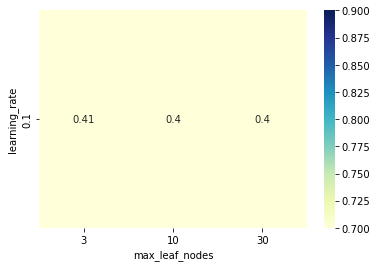

In [122]:
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

## XGBoost

In [124]:
X_encoded = pd.get_dummies(X, columns = ['user_age', 'user_income', 'user_gender',
       'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])


In [135]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]

In [177]:
y = y.replace({'No Segment':0,
               'The Achiever':1,
               'The Maximizer':2,
               'The On-the-Goer':3,
               'The Collector':4,
               'The Safekeeper':5,
               'The Budgeter':6,
               'The Traditionalist':7})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)

In [195]:
selector

RFECV(cv=10,
      estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              eval_metric='mlogloss', gamma=0.25, gpu_id=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=None, max_depth=3,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=100, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None),
 

In [178]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])

[14:22:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.86728
[1]	validation_0-mlogloss:1.74037
[2]	validation_0-mlogloss:1.65395
[3]	validation_0-mlogloss:1.59219
[4]	validation_0-mlogloss:1.54546
[5]	validation_0-mlogloss:1.51070
[6]	validation_0-mlogloss:1.48268
[7]	validation_0-mlogloss:1.46504
[8]	validation_0-mlogloss:1.44727
[9]	validation_0-mlogloss:1.43286
[10]	validation_0-mlogloss:1.42200
[11]	validation_0-mlogloss:1.41212
[12]	validation_0-mlogloss:1.40518
[13]	validation_0-mlogloss:1.39697
[14]	validation_0-mlogloss:1.39303
[15]	validation_0-mlogloss:1.38869
[16]	validation_0-mlogloss:1.38568
[17]	validation_0-mlogloss:1.38259
[18]	validation_0-mlogloss:1.37798
[19]	validation_0-mlogloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

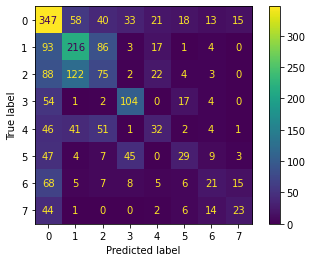

In [179]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')

In [181]:
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=0, monotone_constraints=None,
                                     n_...
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=None, reg_alpha=None,
                                

In [182]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 3, 'reg_lambda': 10.0}


In [183]:
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))

0.33165769656508287

In [184]:
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))

Confusion Matrix (Accuracy 0.4708)

       Prediction
Actual    0    1    2    3    4    5    6    7
     0 1570  274   39  135   26   48   23   61
     1  438 1109   78   12   35    3    4    2
     2  411  593  180    9   61    4    5    2
     3  186   24    8  462    1   40    7    0
     4  252  240   85    7  108    5   11    5
     5  223   15    7  182    3  121   18    8
     6  295   33    7   46    5   23   71   58
     7  140    6    7    3    4   13   24  164
Confusion Matrix (Accuracy 0.4289)

       Prediction
Actual   0   1   2   3   4   5   6   7
     0 393  63  12  33   7  10   6  21
     1 126 249  28   2  10   0   3   2
     2 108 146  33   3  21   1   3   1
     3  51   4   0 110   0  14   3   0
     4  55  70  24   1  21   2   2   3
     5  52   8   4  53   0  21   3   3
     6  72   9   6  12   3   8   6  19
     7  44   2   0   2   1   1  11  29


In [185]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0.25],
    'reg_lambda':[10,20,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=0, monotone_constraints=None,
                                     n_...jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=None, reg_alpha=None,
                      

In [186]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 100}


In [187]:
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))

0.345252805013046

In [188]:
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))

Confusion Matrix (Accuracy 0.4849)

       Prediction
Actual    0    1    2    3    4    5    6    7
     0 1529  290   58  129   32   53   29   56
     1  387 1122  116   14   32    4    4    2
     2  372  536  264   10   71    4    6    2
     3  175   25    9  461    1   49    6    2
     4  215  219  118    7  135    5    8    6
     5  208   15    8  171    3  143   19   10
     6  277   29   14   45    7   28   84   54
     7  136    6    7    3    8   10   31  160
Confusion Matrix (Accuracy 0.4378)

       Prediction
Actual   0   1   2   3   4   5   6   7
     0 378  71  13  37  10  11  10  15
     1 109 256  40   1   9   1   2   2
     2  97 142  49   4  20   1   2   1
     3  46   4   0 112   1  16   3   0
     4  45  62  38   1  23   2   5   2
     5  48   5   4  53   0  24   7   3
     6  66  11   6  11   4  11   8  18
     7  42   2   1   2   0   3  10  30


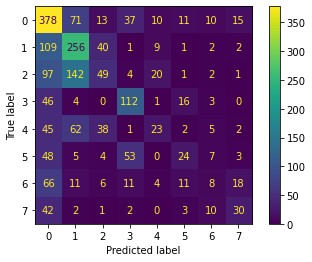

In [189]:
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')

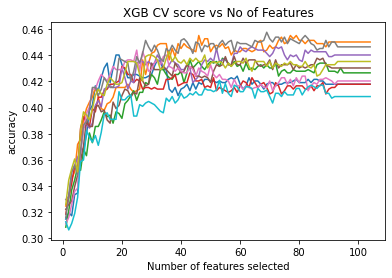

In [193]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0.25, learning_rate= 0.1, max_depth= 3, reg_lambda= 100, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())


#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)

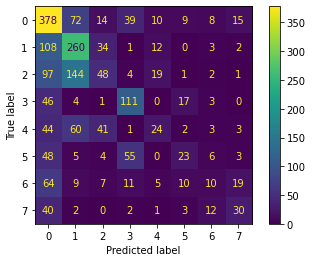

In [196]:
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')

In [210]:
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

,feature,weight
0,user_region_Man/Sask,0.085453
1,user_age_45 - 54,0.068617
2,Miscellaneous/credit,0.067986
3,user_lifestage_Couple no kids,0.049889
4,user_age_25 - 34,0.040380
5,grocery/Interac,0.038508
6,Miscellaneous/Other,0.038445
7,user_age_15 - 24,0.036101
8,user_lifestage_Couple with Older Kids,0.033810
9,user_region_North,0.022984


# Modelling(without 'no segment')

In [3]:

data_final = pd.read_csv('final_data.csv')
X = data_final[data_final['user_segment']!='No Segment'].drop(columns=['user_segment','rid'])
y = data_final[data_final['user_segment']!='No Segment']['user_segment']
y.value_counts()
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_columns
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_age', 'user_income',
                                                   'user_gender', 'user_region',
                                                   'user_education',
                                                   'user_lifestage',
                                                   'user_immigrant_status',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                     

## HistGradientBoostingClassifier


In [3]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
y_test.value_counts()
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()



The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}
The test accuracy score of the grid-searched pipeline is: 0.74
The test accuracy score of the grid-searched pipeline is: 0.47
no display found. Using non-interactive Agg backend
Confusion Matrix (Accuracy 0.7361)

       Prediction
Actual    0    1    2    3    4    5    6
     0 1447   10   52  157   11    3    0
     1   25  380   13   26   36   32   26
     2  189   17  358  128    5    7    9
     3  430   11   76  731    7    5    5
     4   10    8    1    8  661   40    0
     5   13   27    8   10   97  417    5
     6    2   15    7    3    3   10  321
Confusion Matrix (Accuracy 0.4659)

       Prediction
Actual   0   1   2   3   4   5   6
     0 279  13  30  86   9   2   2
     1  15  48   5  11  18  17  21
     2  54  13  46  56   5   2   2
     3 1

## XGBoost


[08:55:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.71860
[1]	validation_0-mlogloss:1.59096
[2]	validation_0-mlogloss:1.50508
[3]	validation_0-mlogloss:1.44451


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[4]	validation_0-mlogloss:1.39794
[5]	validation_0-mlogloss:1.36744
[6]	validation_0-mlogloss:1.34101
[7]	validation_0-mlogloss:1.32320
[8]	validation_0-mlogloss:1.30731
[9]	validation_0-mlogloss:1.29267
[10]	validation_0-mlogloss:1.28153
[11]	validation_0-mlogloss:1.27408
[12]	validation_0-mlogloss:1.26863
[13]	validation_0-mlogloss:1.26523
[14]	validation_0-mlogloss:1.26141
[15]	validation_0-mlogloss:1.25821
[16]	validation_0-mlogloss:1.25654
[17]	validation_0-mlogloss:1.25524
[18]	validation_0-mlogloss:1.25281
[19]	validation_0-mlogloss:1.25299
[20]	validation_0-mlogloss:1.25229
[21]	validation_0-mlogloss:1.25419
[22]	validation_0-mlogloss:1.25428
[23]	validation_0-mlogloss:1.25109
[24]	validation_0-mlogloss:1.25082
[25]	validation_0-mlogloss:1.25139
[26]	validation_0-mlogloss:1.25203
[27]	validation_0-mlogloss:1.25254
[28]	validation_0-mlogloss:1.25368
[29]	validation_0-mlogloss:1.25582
[30]	validation_0-mlogloss:1.25675
[31]	validation_0-mlogloss:1.25917
[32]	validation_0-mlogloss

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0}
no display found. Using non-interactive Agg backend
Confusion Matrix (Accuracy 0.6506)

       Prediction
Actual    0    1    2    3    4    5    6
     0 1431  171   10   39    8   19    2
     1  567  589    9   78    3   15    4
     2   17    8  627    3   56   17    0
     3  264  166    9  240    8   18    8
     4   16   15  152    9  340   30   15
     5   41   34   48   13   41  312   49
     6    8    7    6   14   16   35  275
Confusion Matrix (Accuracy 0.4693)

       Prediction
Actual   0   1   2   3   4   5   6
     0 330  67   5  12   3   3   1
     1 192  85   4  27   1   5   2
     2  15   4 124   0  37   2   0
     3  76  63   3  23   2   6   5
     4   4   7  65   1  43  19   5
     5  14  13  13  11  21  39  24
     6   1   1   3   8   9  24  44
The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 20}
Confusion Matrix

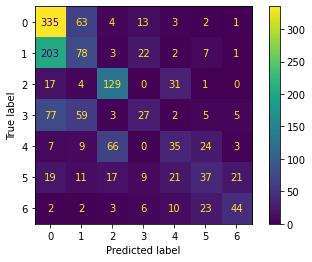

In [4]:
X_encoded = pd.get_dummies(X, columns = ['user_age', 'user_income', 'user_gender',
       'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
y = y.replace({'The Achiever':0,
               'The Maximizer':1,
               'The On-the-Goer':2,
               'The Collector':3,
               'The Safekeeper':4,
               'The Budgeter':5,
               'The Traditionalist':6})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)
selector
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0.25],
    'reg_lambda':[10,20,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')


## RFECV

,feature,weight
0,Miscellaneous/Cash,0.119134
1,num_online,0.090707
2,Liquor/credit,0.080019
3,Miscellaneous/Interac,0.072901
4,num_inperson,0.059844
5,grocery/Interac,0.036224
6,personal/Cash,0.034490
7,user_debit_tap_availability,0.032227
8,grocery/credit,0.022804
9,personal/Interac,0.020377


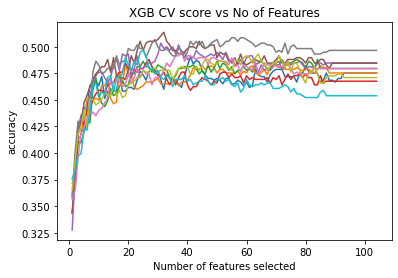

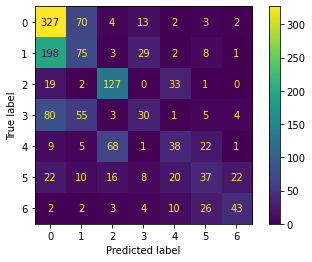

In [5]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0.25, learning_rate= 0.1, max_depth= 3, reg_lambda= 20, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())

#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

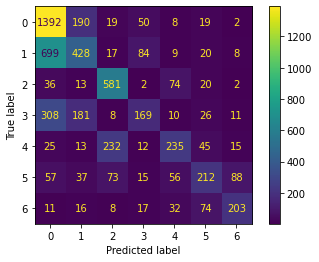

In [28]:
plot_confusion_matrix(selector,
                      X_train,
                      y_train,
                      values_format='d')

# Modelling without transaction data

In [33]:
data_final = pd.read_csv('final_data.csv')
data_final = data_final[['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_segment', 'num_online',
       'num_inperson', 'num_other', 'num_lp', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']]

X = data_final[data_final['user_segment']!='No Segment'].drop(columns=['user_segment'])
y = data_final[data_final['user_segment']!='No Segment']['user_segment']
y.value_counts()
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_columns
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_age', 'user_income',
                                                   'user_gender', 'user_region',
                                                   'user_education',
                                                   'user_lifestage',
                                                   'user_immigrant_status',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                     

## HistGradientBoost

The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}
The test accuracy score of the grid-searched pipeline is: 0.57
The test accuracy score of the grid-searched pipeline is: 0.41
Confusion Matrix (Accuracy 0.5747)

       Prediction
Actual    0    1    2    3    4    5    6
     0 1305   29   58  203   39   38    8
     1   78  227   13   48   66   59   47
     2  221   19  273  148   12   28   12
     3  519   38   94  540   34   28   12
     4   66   20    9   48  515   64    6
     5   43   37   21   40  139  272   25
     6   14   38    9   23   12   28  237
Confusion Matrix (Accuracy 0.4141)

       Prediction
Actual   0   1   2   3   4   5   6
     0 280   6  27  84  11  10   3
     1  29  32   6   9  19  18  22
     2  54   8  47  54   3   7   5
     3 170   8  44  70   7  15   2
     4  23   8   1  13 10

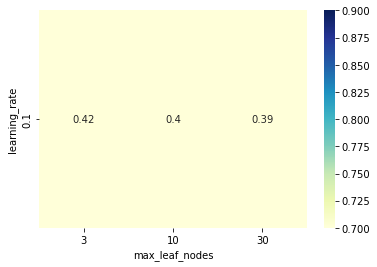

In [34]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
y_test.value_counts()
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

## XGBoost

[13:17:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.76622
[1]	validation_0-mlogloss:1.66499
[2]	validation_0-mlogloss:1.59952
[3]	validation_0-mlogloss:1.55270
[4]	validation_0-mlogloss:1.51901
[5]	validation_0-mlogloss:1.49457
[6]	validation_0-mlogloss:1.47295
[7]	validation_0-mlogloss:1.45894
[8]	validation_0-mlogloss:1.44907
[9]	validation_0-mlogloss:1.44214
[10]	validation_0-mlogloss:1.43638
[11]	validation_0-mlogloss:1.43007
[12]	validation_0-mlogloss:1.42595
[13]	validation_0-mlogloss:1.42389
[14]	validation_0-mlogloss:1.42352
[15]	validation_0-mlogloss:1.42424
[16]	validation_0-mlogloss:1.42328
[17]	validation_0-mlogloss:1.42208
[18]	validation_0-mlogloss:1.42225
[19]	validation_0-mlogloss:

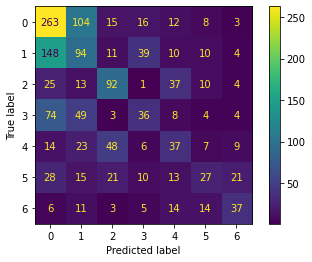

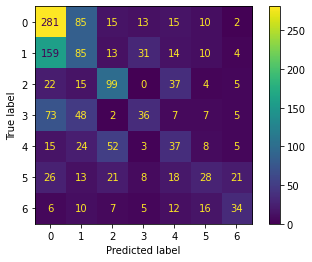

In [35]:
X_encoded = pd.get_dummies(X, columns = ['user_age', 'user_income', 'user_gender',
       'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
y = y.replace({'The Achiever':0,
               'The Maximizer':1,
               'The On-the-Goer':2,
               'The Collector':3,
               'The Safekeeper':4,
               'The Budgeter':5,
               'The Traditionalist':6})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)
selector
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0.25],
    'reg_lambda':[10,20,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')

## RFECV

,feature,weight
0,user_lifestage_Couple no kids,0.149537
1,user_lifestage_Couple with younger kids,0.126639
2,user_lifestage_Couple with Older Kids,0.126145
3,user_lifestage_Couple no Kids,0.084902
4,user_smartphone_usage,0.029498
5,user_debit_tap_availability,0.023804
6,user_income_$30k - $59k,0.022659
7,num_other,0.017065
8,user_lifestage_Empty nesters,0.016201
9,user_main_bank_CIBC,0.016097


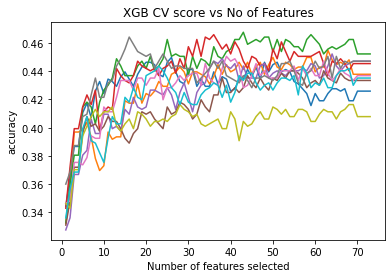

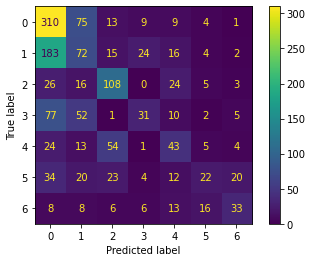

In [38]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0, learning_rate= 0.1, max_depth= 3, reg_lambda= 10, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())

#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

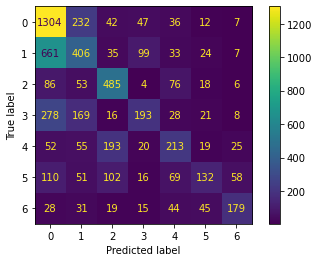

In [39]:
plot_confusion_matrix(selector,
                      X_train,
                      y_train,
                      values_format='d')

In [40]:
len(X_encoded.columns)

73

# Modelling with Collapsed segments（with no transaction data)

In [4]:
data_final = pd.read_csv('final_data.csv')
# ordinal categorical variables: 'user_age', 'user_income','user_education', 'user_lifestage',
# 'user_immigrant_status'

data_final = data_final[['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_segment', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']]

X = data_final[data_final['user_segment']!='No Segment'].drop(columns=['user_segment'])
y = data_final[data_final['user_segment']!='No Segment']['user_segment']
y = y.replace({'The Achiever':'Heavy Credit',
           'The Maximizer':'Heavy Credit',
           'The Collector':'Heavy Credit',
           'The On-the-Goer':'Heavy Debit',
           'The Safekeeper':'Heavy Debit',
           'The Budgeter':'Heavy Cash',
           'The Traditionalist':'Heavy Cash'})
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_columns
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_age', 'user_income',
                                                   'user_gender', 'user_region',
                                                   'user_education',
                                                   'user_lifestage',
                                                   'user_immigrant_status',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                     

## HistGradientBoost

In [5]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The train accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
y_test.value_counts()
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}
The test accuracy score of the grid-searched pipeline is: 0.82
The test accuracy score of the grid-searched pipeline is: 0.77
no display found. Using non-interactive Agg backend
Confusion Matrix (Accuracy 0.8158)

       Prediction
Actual    0    1    2
     0  371  307  221
     1   62 3467  129
     2   89  272  944
Confusion Matrix (Accuracy 0.7688)

       Prediction
Actual   0   1   2
     0  86  86  53
     1  28 836  51
     2  34  87 205


## XGBoost

In [6]:
X_encoded = pd.get_dummies(X, columns = ['user_age', 'user_income', 'user_gender',
       'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
y = y.replace({'Heavy Credit':0,
               'Heavy Debit':1,
               'Heavy Cash':2})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)
selector
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0.25],
    'reg_lambda':[10,20,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')

[17:10:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.88438
[1]	validation_0-mlogloss:0.76457
[2]	validation_0-mlogloss:0.68964
[3]	validation_0-mlogloss:0.64020
[4]	validation_0-mlogloss:0.60761
[5]	validation_0-mlogloss:0.58524
[6]	validation_0-mlogloss:0.57027
[7]	validation_0-mlogloss:0.56150
[8]	validation_0-mlogloss:0.55608
[9]	validation_0-mlogloss:0.55202
[10]	validation_0-mlogloss:0.54806
[11]	validation_0-mlogloss:0.54523
[12]	validation_0-mlogloss:0.54515
[13]	validation_0-mlogloss:0.54414
[14]	validation_0-mlogloss:0.54377
[15]	validation_0-mlogloss:0.54375


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16]	validation_0-mlogloss:0.54296
[17]	validation_0-mlogloss:0.54214
[18]	validation_0-mlogloss:0.54215
[19]	validation_0-mlogloss:0.54239
[20]	validation_0-mlogloss:0.54411
[21]	validation_0-mlogloss:0.54486
[22]	validation_0-mlogloss:0.54481
[23]	validation_0-mlogloss:0.54668
[24]	validation_0-mlogloss:0.54696
[25]	validation_0-mlogloss:0.54766
[26]	validation_0-mlogloss:0.54816
[27]	validation_0-mlogloss:0.54954
[28]	validation_0-mlogloss:0.55041
[29]	validation_0-mlogloss:0.55089
[30]	validation_0-mlogloss:0.55119
[31]	validation_0-mlogloss:0.55370
[32]	validation_0-mlogloss:0.55390
[33]	validation_0-mlogloss:0.55434
[34]	validation_0-mlogloss:0.55561
[35]	validation_0-mlogloss:0.55715
[36]	validation_0-mlogloss:0.55836
[37]	validation_0-mlogloss:0.56046
[38]	validation_0-mlogloss:0.56212
[39]	validation_0-mlogloss:0.56274
[40]	validation_0-mlogloss:0.56360
[41]	validation_0-mlogloss:0.56498
[42]	validation_0-mlogloss:0.56640
[43]	validation_0-mlogloss:0.56652
[44]	validation_0-ml

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


The best set of parameters is: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1.0}
Confusion Matrix (Accuracy 0.8151)

       Prediction
Actual    0    1    2
     0 3517   97   44
     1  340  903   62
     2  347  194  358
Confusion Matrix (Accuracy 0.7926)

       Prediction
Actual   0   1   2
     0 876  24  15
     1  86 216  24
     2 102  53  70
The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.5, 'max_depth': 3, 'reg_lambda': 100}
Confusion Matrix (Accuracy 0.8067)

       Prediction
Actual    0    1    2
     0 3480  124   54
     1  326  896   83
     2  330  216  353
Confusion Matrix (Accuracy 0.7879)

       Prediction
Actual   0   1   2
     0 864  29  22
     1  81 218  27
     2  93  59  73


## RFECV

In [7]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0.25, learning_rate= 0.1, max_depth= 3, reg_lambda= 10, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())

#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

,feature,weight
0,user_education_Some University/College,0.239832
1,user_education_High School or Less,0.239661
2,user_education_Advanced Degree,0.222840
3,user_region_Quebec,0.082927
4,user_immigrant_status_Less than 10 Years in Canada,0.021906
...,...,...
35,user_lifestage_Couple with younger kids,0.003326
36,user_income_$100k+,0.003292
37,user_region_British Columbia,0.003207
38,user_income_$30K - $59K,0.003064


In [8]:
classificationSummary(y_train, selector.predict(X_train))
classificationSummary(y_test, selector.predict(X_test))

Confusion Matrix (Accuracy 0.7960)

       Prediction
Actual    0    1    2
     0 3515  107   36
     1  383  855   67
     2  394  209  296
Confusion Matrix (Accuracy 0.7872)

       Prediction
Actual   0   1   2
     0 882  21  12
     1  99 205  22
     2 106  52  67


In [13]:
selector

sklearn.compose._column_transformer.make_column_selector

# Modelling with Collapsed Segments(with transaction data)

In [15]:

data_final = pd.read_csv('final_data.csv')
X = data_final[data_final['user_segment']!='No Segment'].drop(columns=['user_segment','rid'])
y = data_final[data_final['user_segment']!='No Segment']['user_segment']
y = y.replace({'The Achiever':'Heavy Credit',
           'The Maximizer':'Heavy Credit',
           'The Collector':'Heavy Credit',
           'The On-the-Goer':'Heavy Debit',
           'The Safekeeper':'Heavy Debit',
           'The Budgeter':'Heavy Cash',
           'The Traditionalist':'Heavy Cash'})
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_columns
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_age', 'user_income',
                                                   'user_gender', 'user_region',
                                                   'user_education',
                                                   'user_lifestage',
                                                   'user_immigrant_status',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                     

## HistGradientBoostingClassifier


In [16]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
y_test.value_counts()
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()



The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}
The test accuracy score of the grid-searched pipeline is: 0.95
The test accuracy score of the grid-searched pipeline is: 0.87
Confusion Matrix (Accuracy 0.9497)

       Prediction
Actual    0    1    2
     0  741   76   82
     1   26 3609   23
     2   35   53 1217
Confusion Matrix (Accuracy 0.8677)

       Prediction
Actual   0   1   2
     0 147  46  32
     1  32 864  19
     2  38  27 261


## XGBoost


In [18]:
y.value_counts()

Heavy Credit    4573
Heavy Debit     1631
Heavy Cash      1124
Name: user_segment, dtype: int64

In [19]:
X_encoded = pd.get_dummies(X, columns = ['user_age', 'user_income', 'user_gender',
       'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
y = y.replace({'Heavy Credit':0,
            'Heavy Debit':1,
            'Heavy Cash':2})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)
selector
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0.25],
    'reg_lambda':[10,20,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')


[21:22:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.82832
[1]	validation_0-mlogloss:0.67696
[2]	validation_0-mlogloss:0.58070
[3]	validation_0-mlogloss:0.51678
[4]	validation_0-mlogloss:0.47238
[5]	validation_0-mlogloss:0.44154
[6]	validation_0-mlogloss:0.42042
[7]	validation_0-mlogloss:0.40570
[8]	validation_0-mlogloss:0.39560
[9]	validation_0-mlogloss:0.38908
[10]	validation_0-mlogloss:0.38293
[11]	validation_0-mlogloss:0.37848
[12]	validation_0-mlogloss:0.37417
[13]	validation_0-mlogloss:0.36951
[14]	validation_0-mlogloss:0.36882
[15]	validation_0-mlogloss:0.36759
[16]	validation_0-mlogloss:0.36638
[17]	validation_0-mlogloss:0.36619
[18]	validation_0-mlogloss:0.36683
[19]	validation_0-mlogloss:

## RFECV

In [21]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0.25, learning_rate= 0.1, max_depth= 3, reg_lambda= 10, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())

#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

,feature,weight
0,user_region_Man/Sask,0.224246
1,Miscellaneous/credit,0.112492
2,Miscellaneous/Other,0.085708
3,grocery/Interac,0.068935
4,user_region_North,0.058121
...,...,...
68,user_gender_Other,0.001731
69,user_visible_minority,0.001518
70,user_gender_Male,0.001108
71,num_online,0.000847


In [22]:
classificationSummary(y_train, selector.predict(X_train))
classificationSummary(y_test, selector.predict(X_test))

Confusion Matrix (Accuracy 0.9052)

       Prediction
Actual    0    1    2
     0 3555   43   60
     1   96 1144   65
     2  157  135  607
Confusion Matrix (Accuracy 0.8724)

       Prediction
Actual   0   1   2
     0 879  16  20
     1  27 269  30
     2  58  36 131


# Modelling with Collapsed segments（with no transaction data and ordinal categorical variables)

In [102]:
data_final = pd.read_csv('final_data.csv')
# ordinal categorical variables: 'user_age', 'user_income','user_education', 'user_immigrant_status'
data_final['user_age'] = data_final['user_age'].replace({
    '15 - 24':1,
    '25 - 34':2,
    '35 - 44':3,
    '45 - 54':4,
    '55 - 64':5,
    '65+': 6
})

data_final['user_income'] = data_final['user_income'].replace({
    '<$30k':1,
    '$30K - $59K':2,
    '$30k - $59k':2,
    '$60K - $99K':3,
    '$100k+':4 ,
    '$100K+':4
})

data_final['user_education'] = data_final['user_education'].replace({
    'High School or Less':1,
    'Some University/College':2,
    'University/College':3,
    'Advanced Degree':4
})

data_final['user_immigrant_status'] = data_final['user_immigrant_status'].replace({
    'Less than 10 Years in Canada':1,
    '10 Years+ in Canada':2,
    'Canadian Born':3
})

In [106]:
data_final = data_final[['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_segment', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']]

lists = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']

for i in lists:
    data_final[i]=data_final[i].str.lower()

X = data_final[data_final['user_segment']!='No Segment'].drop(columns=['user_segment'])

y = data_final[data_final['user_segment']!='No Segment']['user_segment']
y = y.replace({'The Achiever':'Heavy Credit',
           'The Maximizer':'Heavy Credit',
           'The Collector':'Heavy Credit',
           'The On-the-Goer':'Heavy Debit',
           'The Safekeeper':'Heavy Debit',
           'The Budgeter':'Heavy Cash',
           'The Traditionalist':'Heavy Cash'})
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)
categorical_columns
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=1234,stratify=y)
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier",
     HistGradientBoostingClassifier(random_state=42))])
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['user_gender', 'user_region',
                                                   'user_lifestage',
                                                   'user_payment_preference',
                                                   'user_banking_package',
                                                   'user_main_bank',
                                                   'user_main_debit_card',
                                                   'user_main_credit_card'])])),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

## HistGradientBoost

In [108]:
param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 30),
    'classifier__max_iter': [1000,1200,1500],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth' : [5,10,20,25, 50, 75],
    'classifier__l2_regularization': [1.5],
    'classifier__scoring': ['f1_micro']}
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=5)
model_grid_search.fit(X_train, y_train)
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
accuracy = model_grid_search.score(X_train, y_train)
print(
    f"The train accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
y_test.value_counts()
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

The best set of parameters is: {'classifier__l2_regularization': 1.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__max_iter': 1000, 'classifier__max_leaf_nodes': 3, 'classifier__scoring': 'f1_micro'}
The train accuracy score of the grid-searched pipeline is: 0.82
The test accuracy score of the grid-searched pipeline is: 0.77
Confusion Matrix (Accuracy 0.8159)

       Prediction
Actual    0    1    2
     0  367  305  227
     1   63 3471  124
     2   83  277  945
Confusion Matrix (Accuracy 0.7701)

       Prediction
Actual   0   1   2
     0  83  86  56
     1  25 839  51
     2  28  91 207


In [109]:
filename2 = 'histgradient.sav'
pickle.dump(model_grid_search,open(filename2,'wb'))

## XGBoost

In [40]:
lists = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']
for i in lists:
    X[i]=X[i].str.lower()

X_encoded = pd.get_dummies(X, columns = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
y = y.replace({'Heavy Credit':0,
               'Heavy Debit':1,
               'Heavy Cash':2})
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,test_size=0.2,random_state = 42,stratify=y)

[10:32:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.88342
[1]	validation_0-mlogloss:0.76228
[2]	validation_0-mlogloss:0.68713
[3]	validation_0-mlogloss:0.63900
[4]	validation_0-mlogloss:0.60633
[5]	validation_0-mlogloss:0.58428
[6]	validation_0-mlogloss:0.56980
[7]	validation_0-mlogloss:0.56082
[8]	validation_0-mlogloss:0.55427
[9]	validation_0-mlogloss:0.55047
[10]	validation_0-mlogloss:0.54824
[11]	validation_0-mlogloss:0.54744


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12]	validation_0-mlogloss:0.54633
[13]	validation_0-mlogloss:0.54694
[14]	validation_0-mlogloss:0.54578
[15]	validation_0-mlogloss:0.54557
[16]	validation_0-mlogloss:0.54602
[17]	validation_0-mlogloss:0.54564
[18]	validation_0-mlogloss:0.54476
[19]	validation_0-mlogloss:0.54563
[20]	validation_0-mlogloss:0.54522
[21]	validation_0-mlogloss:0.54578
[22]	validation_0-mlogloss:0.54680
[23]	validation_0-mlogloss:0.54810
[24]	validation_0-mlogloss:0.54881
[25]	validation_0-mlogloss:0.54914
[26]	validation_0-mlogloss:0.54947
[27]	validation_0-mlogloss:0.55073
[28]	validation_0-mlogloss:0.55168
[29]	validation_0-mlogloss:0.55198
[30]	validation_0-mlogloss:0.55288
[31]	validation_0-mlogloss:0.55381
[32]	validation_0-mlogloss:0.55468
[33]	validation_0-mlogloss:0.55521
[34]	validation_0-mlogloss:0.55571
[35]	validation_0-mlogloss:0.55597
[36]	validation_0-mlogloss:0.55653
[37]	validation_0-mlogloss:0.55712
[38]	validation_0-mlogloss:0.55873
[39]	validation_0-mlogloss:0.55954
[40]	validation_0-ml

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


The best set of parameters is: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10.0}
no display found. Using non-interactive Agg backend
Confusion Matrix (Accuracy 0.8038)

       Prediction
Actual    0    1    2
     0 3502  115   41
     1  352  892   61
     2  369  212  318
Confusion Matrix (Accuracy 0.7892)

       Prediction
Actual   0   1   2
     0 876  26  13
     1  86 214  26
     2 101  57  67
The best set of parameters is: {'gamma': 0.25, 'learning_rate': 0.5, 'max_depth': 4, 'reg_lambda': 100}
Confusion Matrix (Accuracy 0.8175)

       Prediction
Actual    0    1    2
     0 3479  130   49
     1  299  926   80
     2  314  198  387
Confusion Matrix (Accuracy 0.7872)

       Prediction
Actual   0   1   2
     0 865  29  21
     1  76 213  37
     2  88  61  76


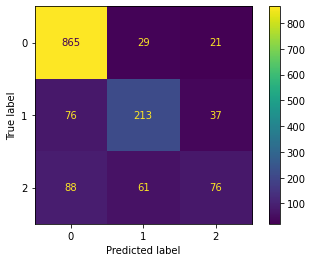

In [11]:
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', missing=0, seed=42)
clf_xgb.fit(X_train,
            y_train, 
            verbose=True, 
            eval_set=[(X_test,y_test)])
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d')
import warnings
warnings.filterwarnings("ignore")
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False, missing=0, seed=42)

param_grid = {
    'max_depth' :[3,4,5],
    'learning_rate':[0.5,0.1,0.05],
    'gamma':[0,0.25,0.5,1],
    'reg_lambda':[10,20,30,40,50,70,90,100]
}
model_grid_search = GridSearchCV(clf_xgb, param_grid=param_grid,
                                 n_jobs=-1, cv=5)
model_grid_search.fit(X_train, y_train,eval_metric='mlogloss')
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")
balanced_accuracy_score(y_test, model_grid_search.predict(X_test))
from dmba import classificationSummary
classificationSummary(y_train, model_grid_search.predict(X_train))
classificationSummary(y_test, model_grid_search.predict(X_test))
plot_confusion_matrix(model_grid_search,
                      X_test,
                      y_test,
                      values_format='d')

In [13]:
filename1 = 'xgb.sav'
pickle.dump(model_grid_search,open(filename1,'wb'))

In [12]:
X_encoded.columns

Index(['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_age', 'user_income',
       'user_education', 'user_immigrant_status', 'user_gender_female',
       'user_gender_male', 'user_gender_other', 'user_region_alberta',
       'user_region_british columbia', 'user_region_east',
       'user_region_man/sask', 'user_region_north', 'user_region_ontario',
       'user_region_quebec', 'user_lifestage_couple no kids',
       'user_lifestage_couple with older kids',
       'user_lifestage_couple with younger kids',
       'user_lifestage_empty nesters', 'user_lifestage_single no kids',
       'user_lifestage_single with kids', 'user_payment_preference_cash',
       'user_payment_preference_credit', 'user_payment_preference_debit',
       'user_payment_preference_mixed', 'user_banking_package_dkna',
       'user_banking_package_limited', 'user_banking_package_unlimited',
       'user_main_bank_bmo', 'user_main_bank_cibc',
       'user_main_bank_desj

## RFECV

,feature,weight
0,user_lifestage_couple with younger kids,0.279122
1,user_lifestage_single no kids,0.249708
2,user_lifestage_empty nesters,0.205627
3,user_lifestage_couple with older kids,0.091783
4,user_main_bank_cibc,0.023409
...,...,...
28,user_smartphone_usage,0.003864
29,user_region_quebec,0.003856
30,user_region_north,0.003791
31,user_region_alberta,0.003602


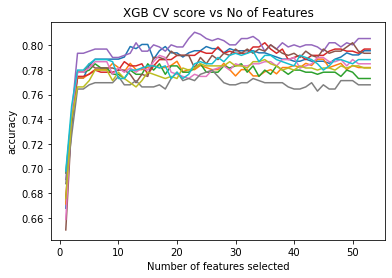

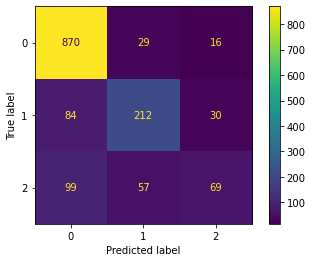

In [41]:
#choose estimator/model type for Recursive feature elimination and cross valiation
estimator = xgb.XGBClassifier(gamma =0, learning_rate= 0.1, max_depth= 4, reg_lambda= 10, eval_metric='mlogloss')
selector = RFECV(estimator, step=1, min_features_to_select=1,scoring="accuracy", cv=10)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_train, y_train.values.flatten())

#PLot # of features selected vs. Model Score
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("accuracy")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

# #get rank of X model features
# rank = selector.ranking_
# #Subset features to those selected by recursive feature elimination
# #X_train_scaled = X_train_scaled[:,selector.support_ ] 

# y_pred = selector.predict(X_train_scaled)
plot_confusion_matrix(selector,
                      X_test,
                      y_test,
                      values_format='d')
pd.set_option('display.max_rows', 100)
pd.DataFrame(
    zip(X_train.columns, abs(selector.estimator_.feature_importances_)),
    columns=["feature", "weight"],
).sort_values("weight",ascending=False).reset_index(drop=True)

In [33]:
classificationSummary(y_train, selector.predict(X_train))
classificationSummary(y_test, selector.predict(X_test))

Confusion Matrix (Accuracy 0.8072)

       Prediction
Actual    0    1    2
     0 3504  112   42
     1  345  892   68
     2  364  199  336
Confusion Matrix (Accuracy 0.7885)

       Prediction
Actual   0   1   2
     0 874  26  15
     1  86 213  27
     2 101  55  69


In [42]:
filename = 'selector.sav'
pickle.dump(selector,open(filename,'wb'))

# Testing on 2021 Data

In [110]:
# data preparation for histgradientboost model
test = pd.read_csv('/Users/xingkaiwu/Desktop/ACP/InteracDashboardFinalv2.csv')
test= test.drop_duplicates(subset = ['rid'])

lists = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']
for i in lists:
    test[i]=test[i].str.lower()

test['user_age'] = test['user_age'].replace({
    '15 - 24':1,
    '25 - 34':2,
    '35 - 44':3,
    '45 - 54':4,
    '55 - 64':5,
    '65+': 6
})

test['user_income'] = test['user_income'].replace({
    '<$30k':1,
    '$30K - $59K':2,
    '$30k - $59k':2,
    '$60K - $99K':3,
    '$100k+':4 ,
    '$100K+':4
})

test['user_education'] = test['user_education'].replace({
    'High School or Less':1,
    'Some University/College':2,
    'University/College':3,
    'Advanced Degree':4
})

test['user_immigrant_status'] = test['user_immigrant_status'].replace({
    'Less than 10 Years in Canada':1,
    '10 Years+ in Canada':2,
    'Canadian Born':3
})

# binary variables, replacing with 1s and 0s
test['user_visible_minority'] = test['user_visible_minority'].replace(
                                {
                                "Not Visible Minority":0,
                                "Visible Minority":1
                                })

test['user_smartphone_usage'] = test['user_smartphone_usage'].replace(
                                {
                                "Non-Smartphone Users":0,
                                "Smartphone Users":1
                                })

test['user_debit_tap_availability'] = test['user_debit_tap_availability'].replace(
                                {
                                "Tap Not Available":0,
                                "DKNA":0,
                                "Tap Available":1
                                })

test = test[['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_segment', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']]

X = test[test['user_segment']!='No Segment'].drop(columns=['user_segment'])
y = test[test['user_segment']!='No Segment']['user_segment']
y = y.replace({'The Achiever':'Heavy Credit',
           'The Maximizer':'Heavy Credit',
           'The Collector':'Heavy Credit',
           'The On-the-Goer':'Heavy Debit',
           'The Safekeeper':'Heavy Debit',
           'The Budgeter':'Heavy Cash',
           'The Traditionalist':'Heavy Cash'})

# X = X.fillna(1)

In [111]:
from sklearn.metrics import plot_confusion_matrix
loaded_model = pickle.load(open('histgradient.sav', 'rb'))
result = loaded_model.score(X, y)
print(result)
classificationSummary(y, loaded_model.predict(X))
plot_confusion_matrix(loaded_model,
                       X,
                       y,
                       values_format='d')

0.8093466635666124
Confusion Matrix (Accuracy 0.8093)

       Prediction
Actual    0    1    2
     0  183  183  136
     1   66 2707  143
     2   76  216  591


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


In [99]:
# data preparation for xgb and RFECV
test = pd.read_csv('/Users/xingkaiwu/Desktop/ACP/InteracDashboardFinalv2.csv')
lists = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']
test= test.drop_duplicates(subset = ['rid'])
for i in lists:
    test[i]=test[i].str.lower()

test['user_age'] = test['user_age'].replace({
    '15 - 24':1,
    '25 - 34':2,
    '35 - 44':3,
    '45 - 54':4,
    '55 - 64':5,
    '65+': 6
})

test['user_income'] = test['user_income'].replace({
    '<$30k':1,
    '$30K - $59K':2,
    '$30k - $59k':2,
    '$60K - $99K':3,
    '$100k+':4 ,
    '$100K+':4
})

test['user_education'] = test['user_education'].replace({
    'High School or Less':1,
    'Some University/College':2,
    'University/College':3,
    'Advanced Degree':4
})



test['user_immigrant_status'] = test['user_immigrant_status'].replace({
    'Less than 10 Years in Canada':1,
    '10 Years+ in Canada':2,
    'Canadian Born':3
})

# binary variables, replacing with 1s and 0s
test['user_visible_minority'] = test['user_visible_minority'].replace(
                                {
                                "Not Visible Minority":0,
                                "Visible Minority":1
                                })

test['user_smartphone_usage'] = test['user_smartphone_usage'].replace(
                                {
                                "Non-Smartphone Users":0,
                                "Smartphone Users":1
                                })

test['user_debit_tap_availability'] = test['user_debit_tap_availability'].replace(
                                {
                                "Tap Not Available":0,
                                "DKNA":0,
                                "Tap Available":1
                                })

test = test[['user_visible_minority', 'user_smartphone_usage',
       'user_debit_tap_availability', 'user_segment', 'user_age', 'user_income',
       'user_gender', 'user_region', 'user_education', 'user_lifestage',
       'user_immigrant_status', 'user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card']]

X = test[test['user_segment']!='No Segment'].drop(columns=['user_segment'])
y = test[test['user_segment']!='No Segment']['user_segment']
y = y.replace({'The Achiever':'Heavy Credit',
           'The Maximizer':'Heavy Credit',
           'The Collector':'Heavy Credit',
           'The On-the-Goer':'Heavy Debit',
           'The Safekeeper':'Heavy Debit',
           'The Budgeter':'Heavy Cash',
           'The Traditionalist':'Heavy Cash'})
X_encoded = pd.get_dummies(X, columns = ['user_gender',
       'user_region', 'user_lifestage','user_payment_preference',
       'user_banking_package', 'user_main_bank', 'user_main_debit_card',
       'user_main_credit_card'])

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_encoded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_encoded.columns.values]
X_encoded['user_main_debit_card_td'] = 0
y = y.replace({'Heavy Credit':0,
               'Heavy Debit':1,
               'Heavy Cash':2})

In [100]:
loaded_model = pickle.load(open('xgb.sav', 'rb'))
result = loaded_model.score(X_encoded, y)
print(result)
classificationSummary(y, loaded_model.predict(X_encoded))
plot_confusion_matrix(loaded_model,
                      X_encoded,
                      y,
                      values_format='d')

0.8105091839107185
Confusion Matrix (Accuracy 0.8105)

       Prediction
Actual    0    1    2
     0 2731  123   62
     1  247  574   62
     2  195  126  181


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


In [101]:
loaded_model = pickle.load(open('selector.sav', 'rb'))
result = loaded_model.score(X_encoded, y)
print(result)
classificationSummary(y, loaded_model.predict(X_encoded))
plot_confusion_matrix(loaded_model,
                      X_encoded,
                      y,
                      values_format='d')

0.8114392001860032
Confusion Matrix (Accuracy 0.8114)

       Prediction
Actual    0    1    2
     0 2764  110   42
     1  272  566   45
     2  216  126  160


The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



# Model Visualization

In [4]:
xgb_model = pickle.load(open('xgb.sav', 'rb'))
best_xgbmodel = xgb_model.best_estimator_

## xgboost model importance

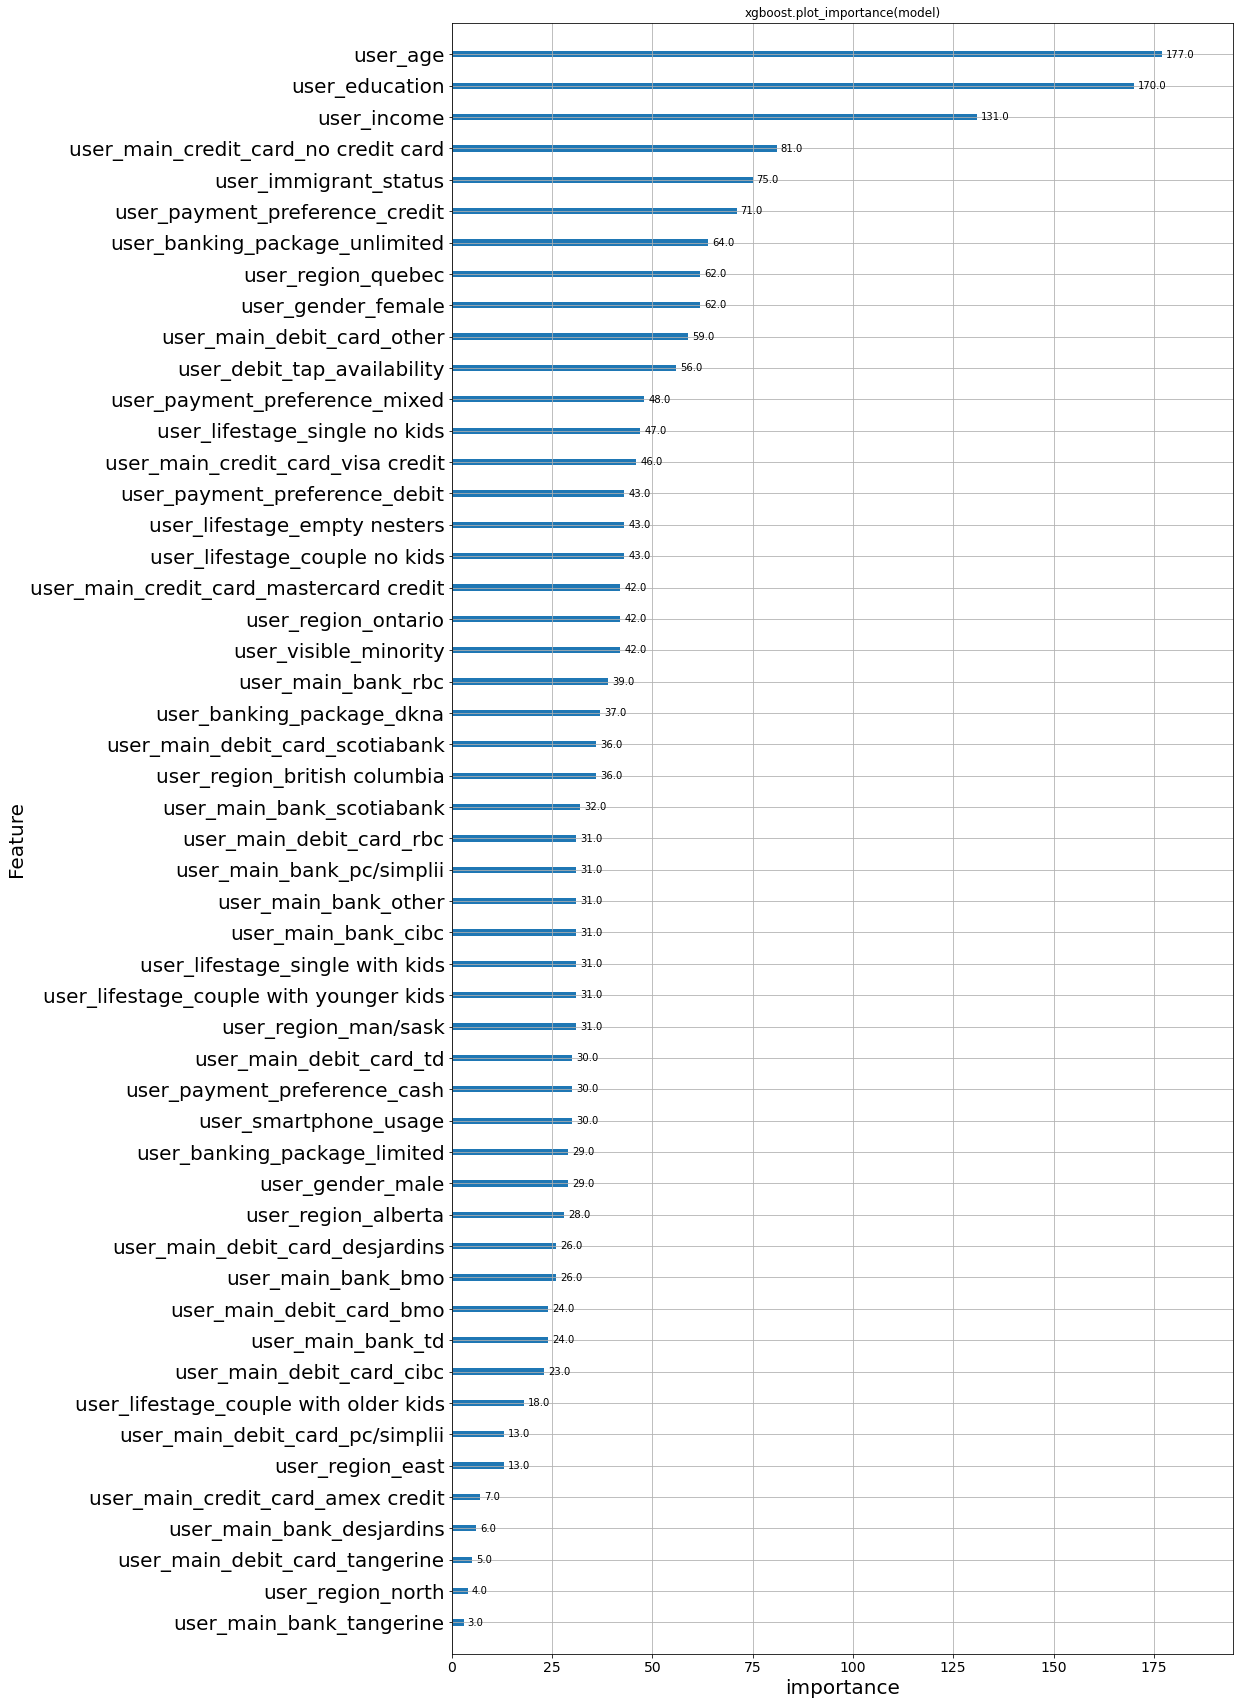

In [5]:
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel)
plt.xlabel('importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

plt.show()

Text(0.5, 1.0, 'xgboost.plot_importance(model)')

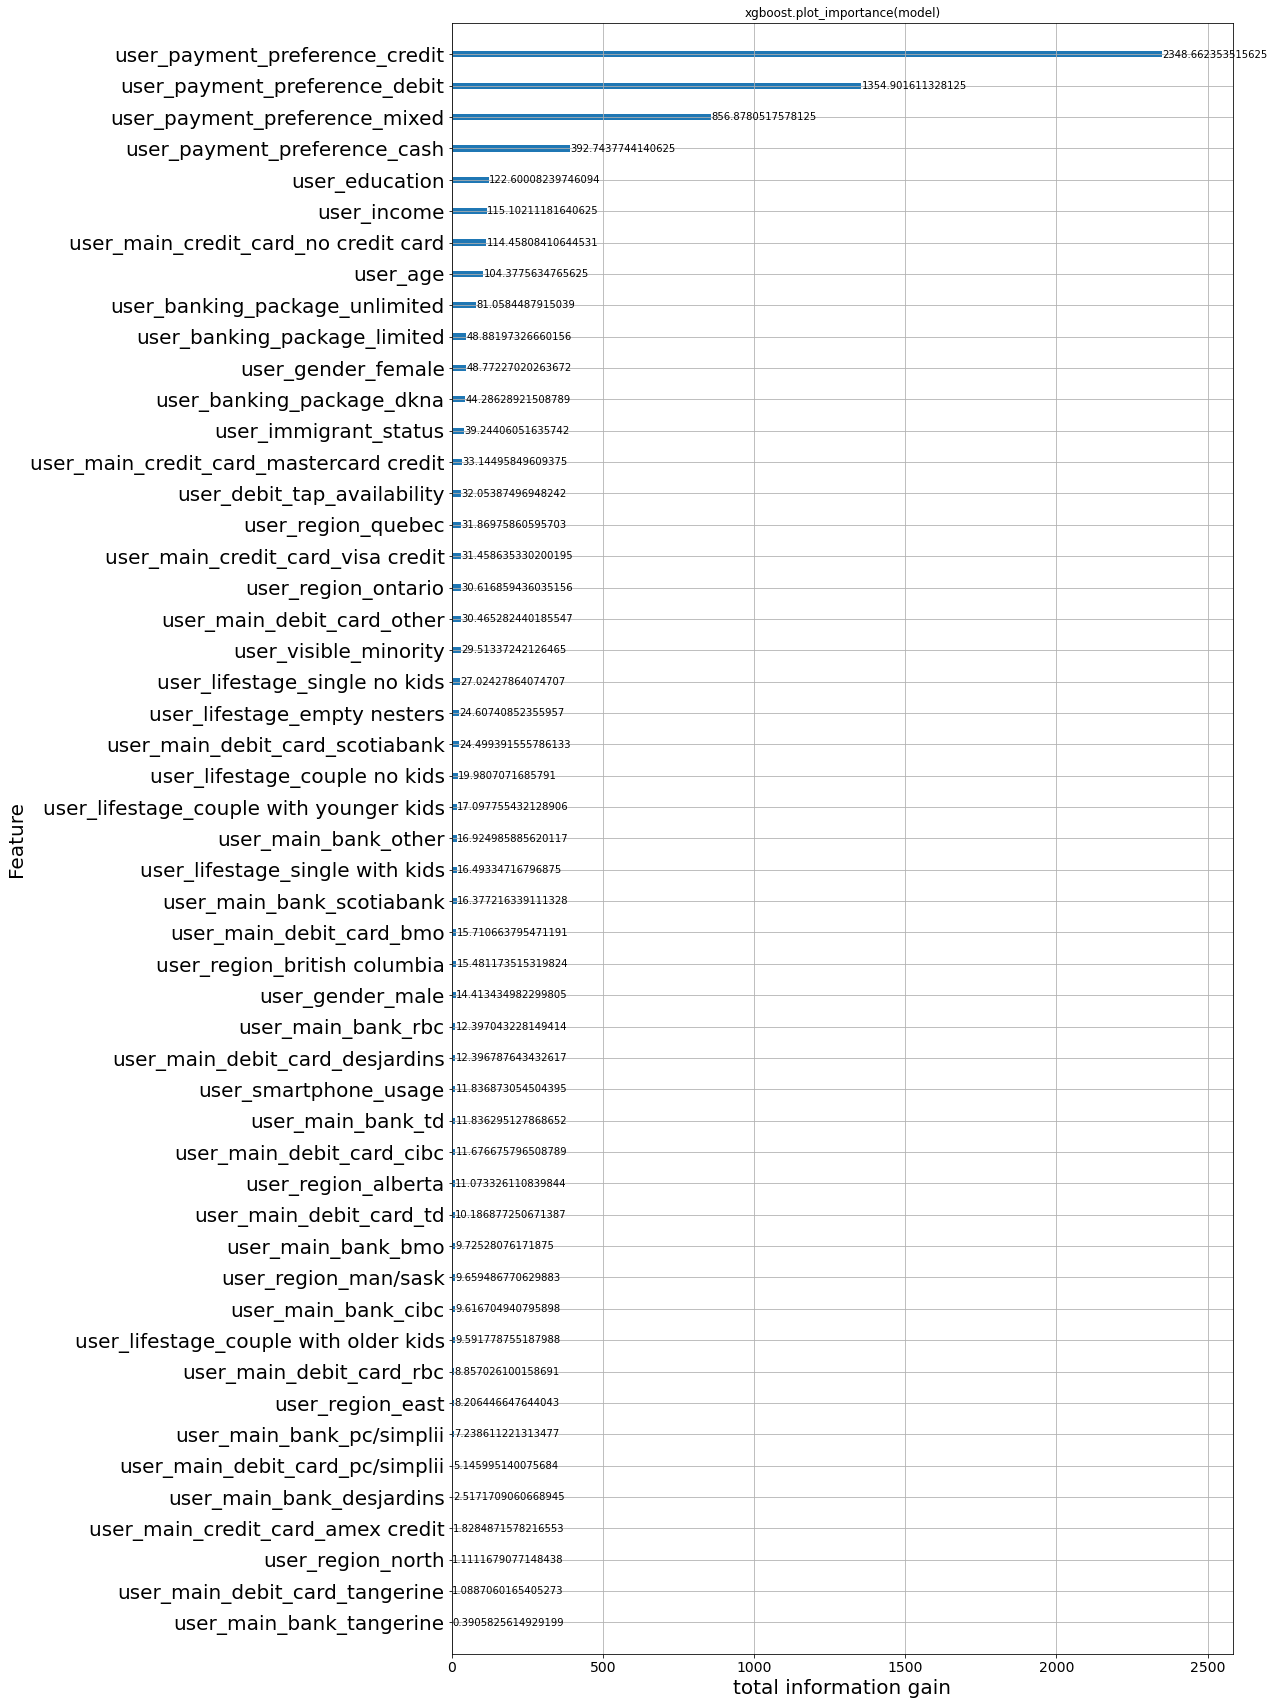

In [6]:
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel, importance_type="total_gain")
plt.xlabel('total information gain', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

Text(0.5, 1.0, 'xgboost.plot_importance(model)')

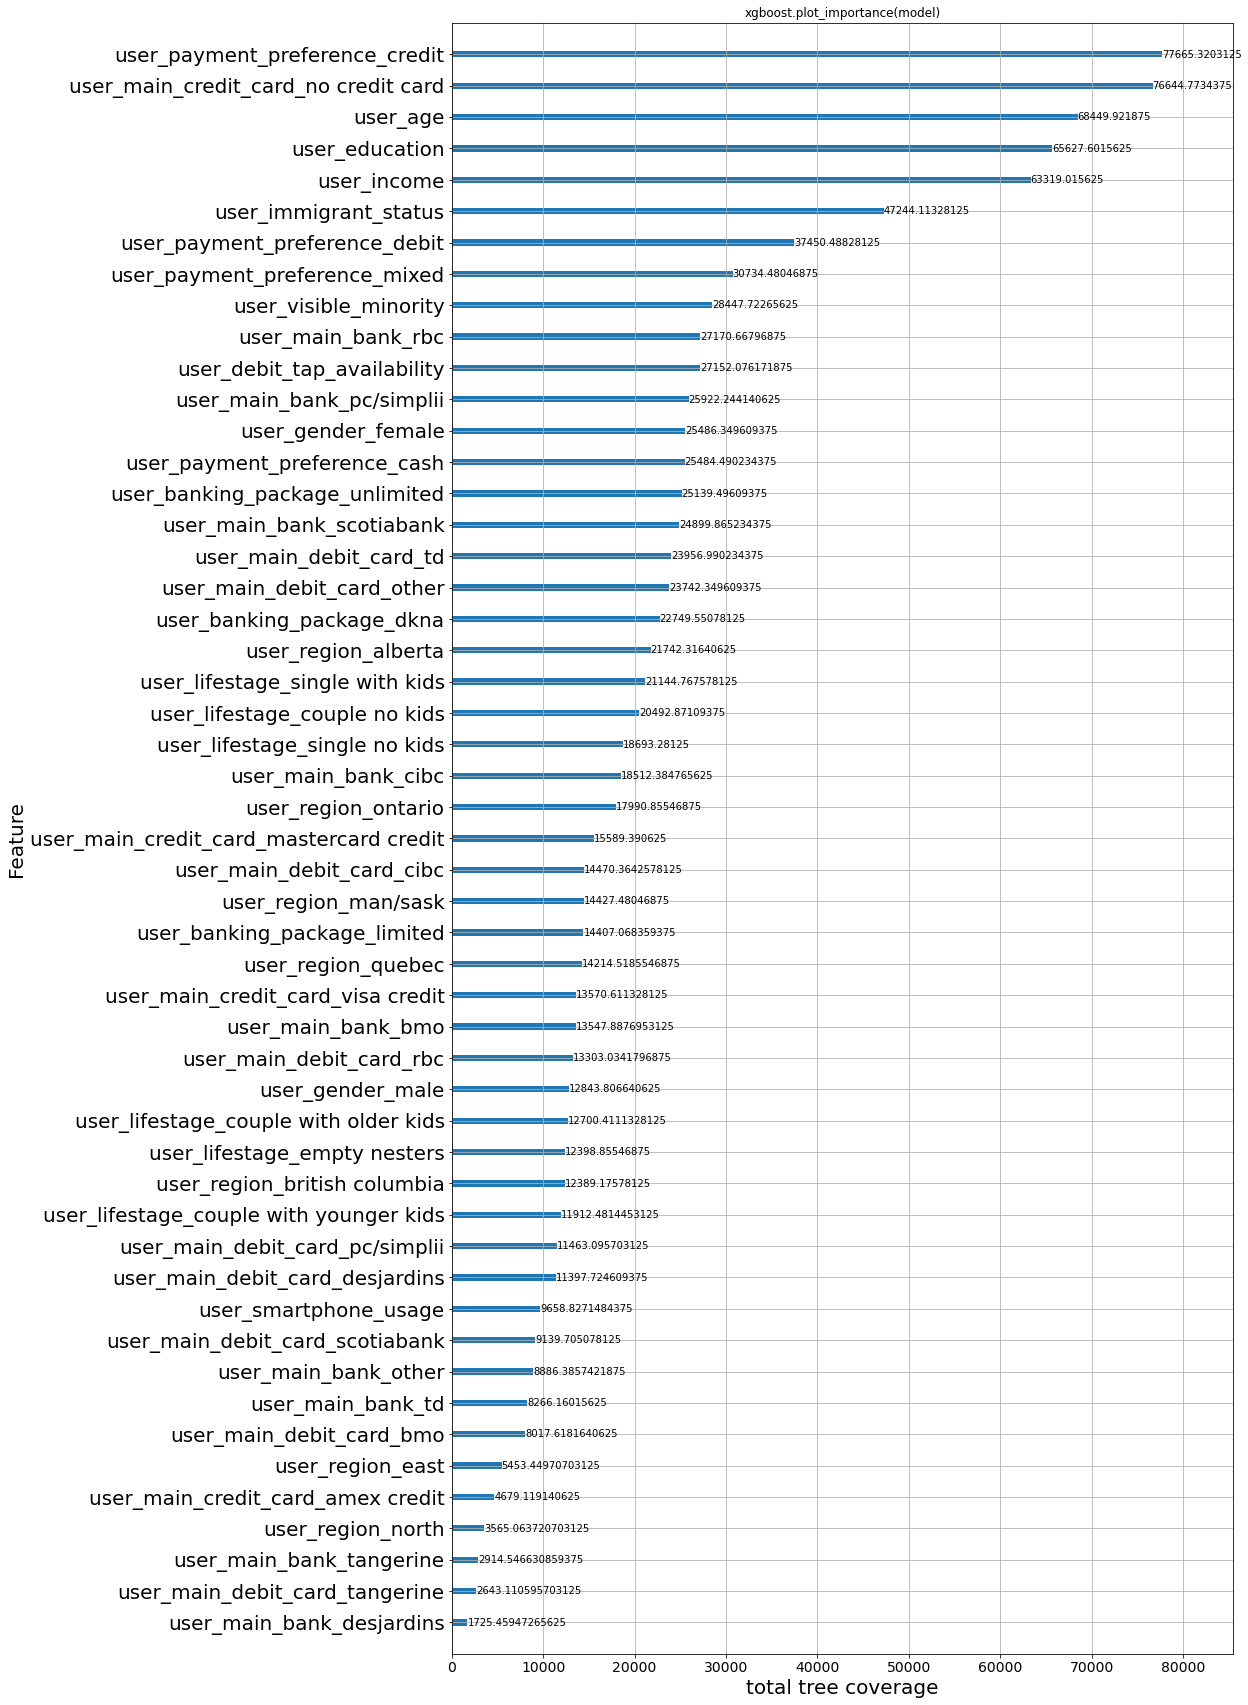

In [7]:
plt.rcParams["figure.figsize"] = (14, 30)
xgb.plot_importance(best_xgbmodel, importance_type="total_cover")
plt.xlabel('total tree coverage', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=14)
plt.title("xgboost.plot_importance(model)")

## Bar chart of mean importance


In [8]:
explainer = shap.TreeExplainer(best_xgbmodel)
shap_values = explainer.shap_values(X_encoded)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [11]:
explainer.expected_value

[1.381706, 0.17312458, -0.030861318]

In [81]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_encoded.iloc[0,:])

In [9]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_encoded.iloc[0,:])

In [10]:
shap.force_plot(explainer.expected_value[2], shap_values[2][0,:], X_encoded.iloc[0,:])

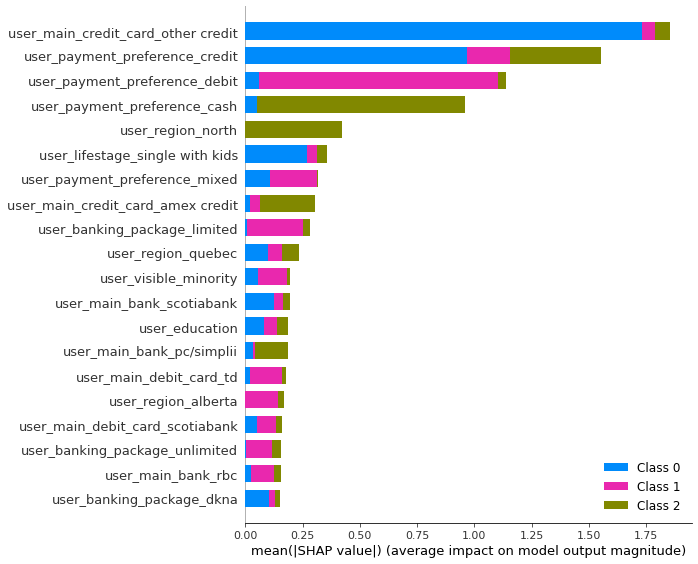

In [65]:
shap.summary_plot(shap_values, X_encoded, plot_type="bar")


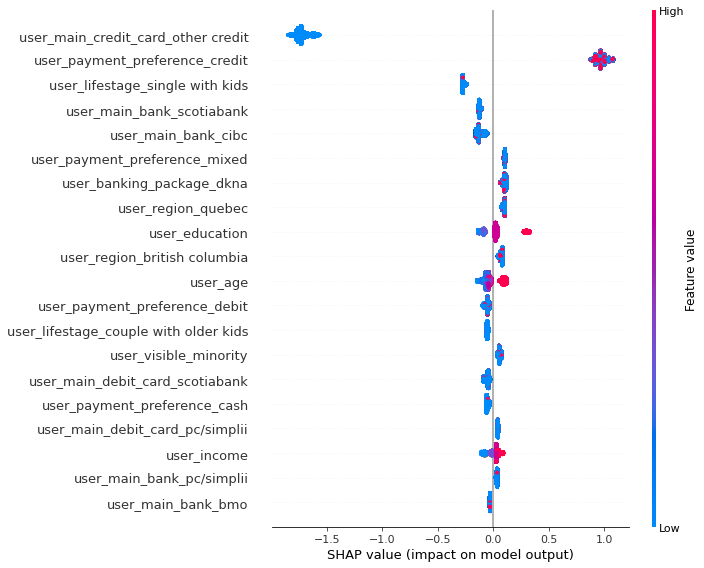

In [21]:
shap.summary_plot(shap_values[0], features=X_encoded.values, feature_names=X_encoded.columns)


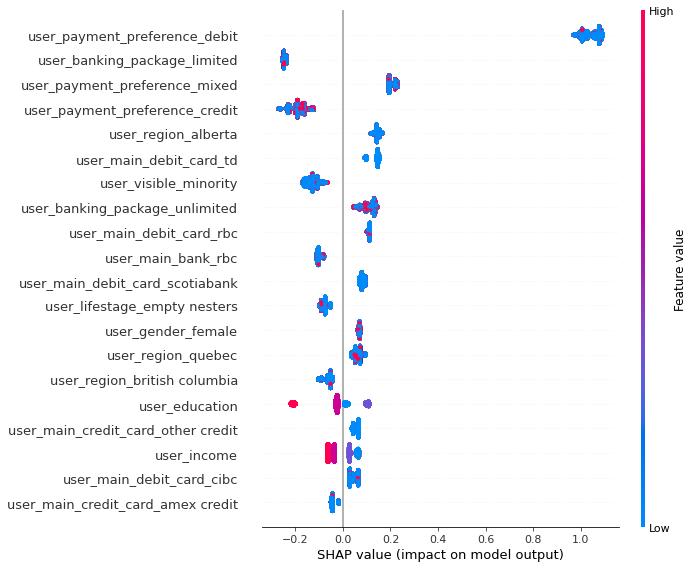

In [22]:
shap.summary_plot(shap_values[1], features=X_encoded.values, feature_names=X_encoded.columns)


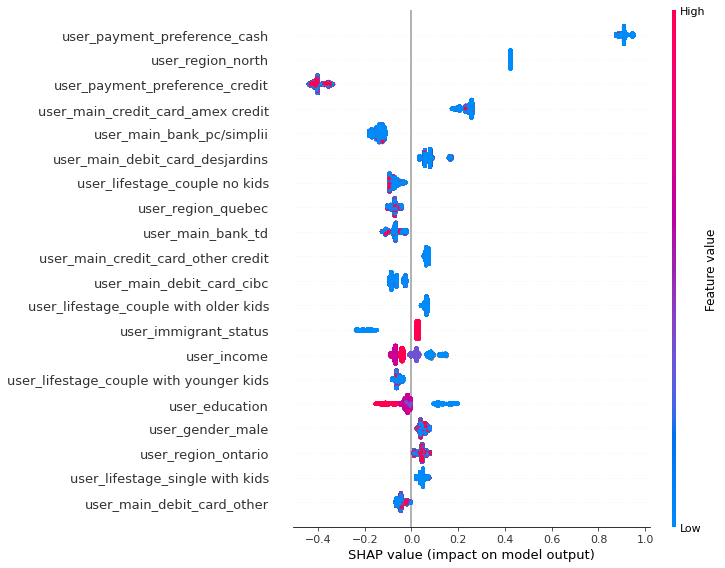

In [23]:
shap.summary_plot(shap_values[2], features=X_encoded.values, feature_names=X_encoded.columns)


## SHAP Dependence Plots

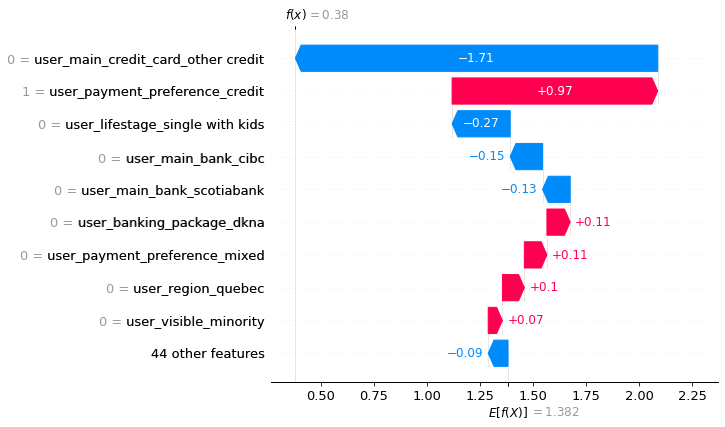

In [25]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_encoded.iloc[row],  
                                         feature_names=X_encoded.columns.tolist()))

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


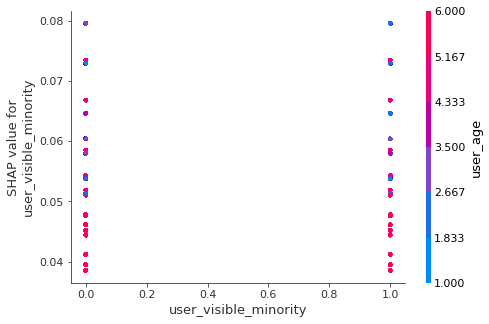

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


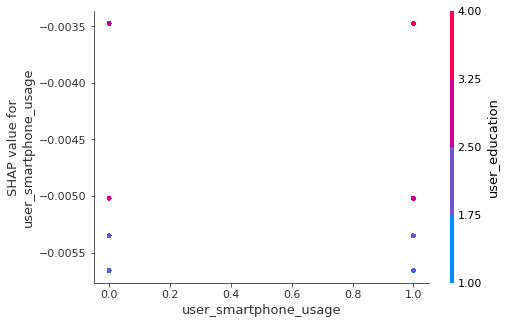

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


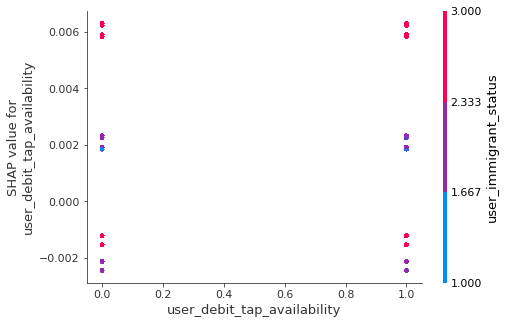

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


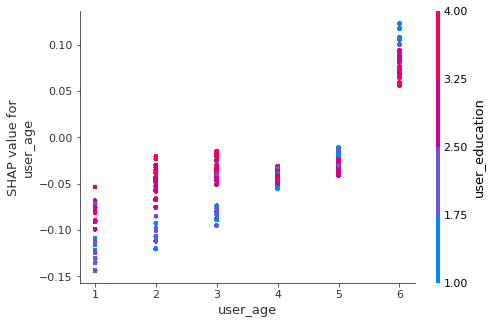

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


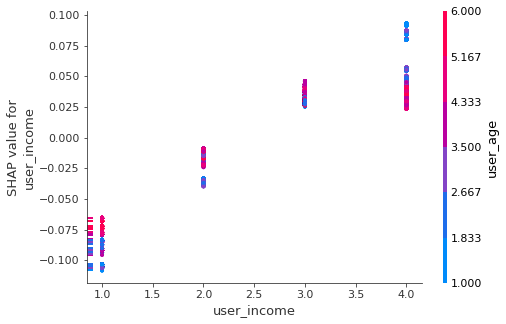

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


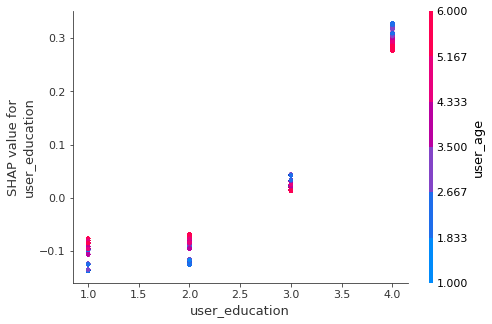

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


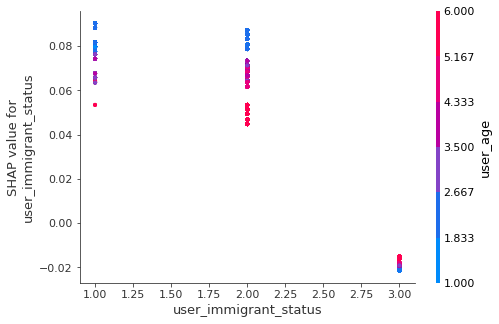

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


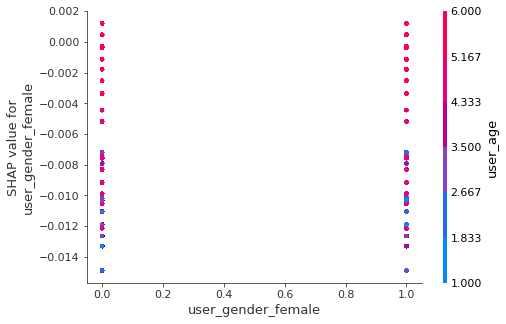

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


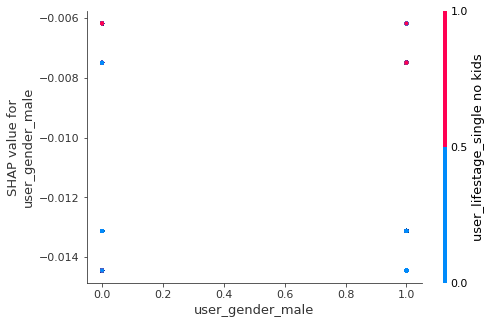

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


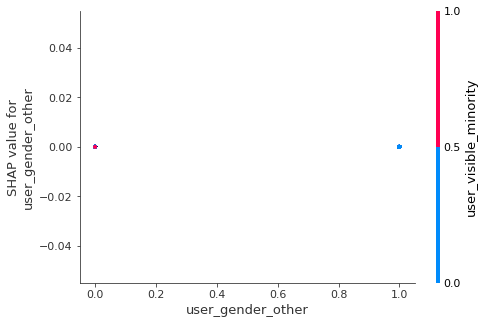

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


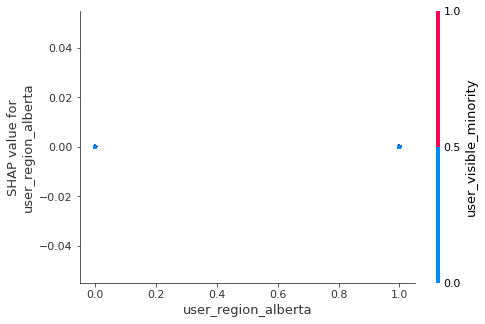

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


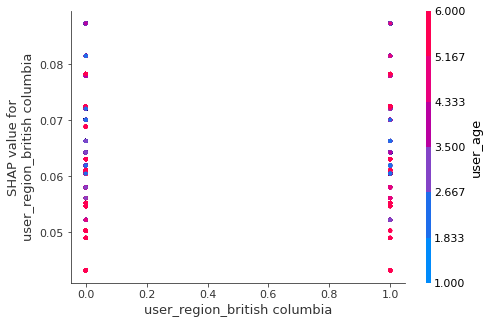

invalid value encountered in true_divide
invalid value encountered in true_divide


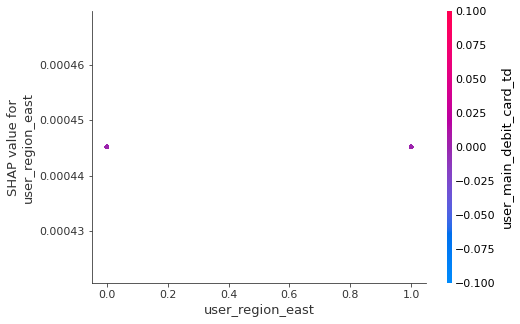

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


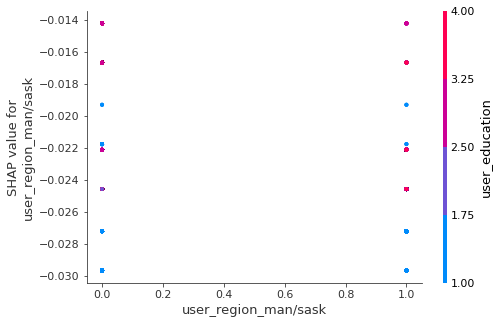

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


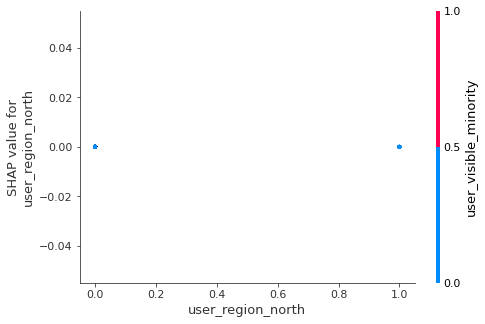

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


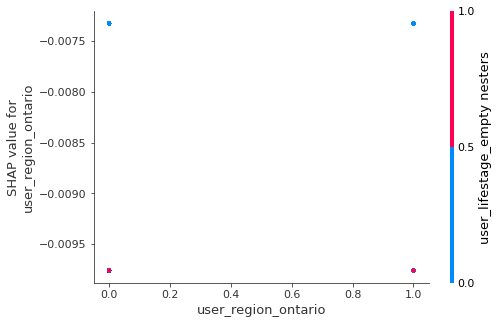

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


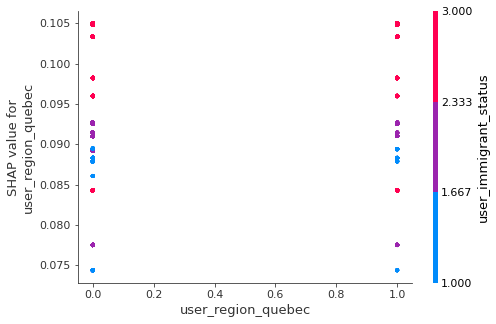

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


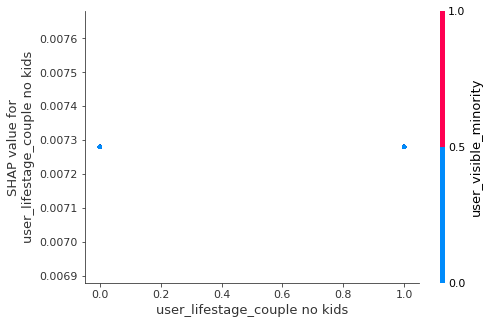

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


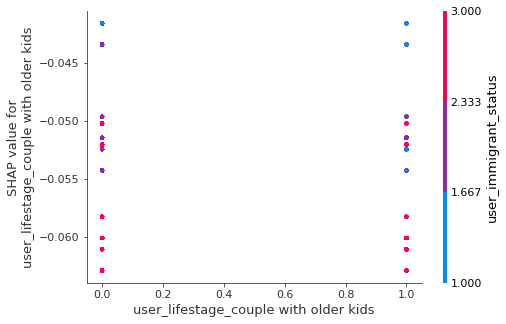

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


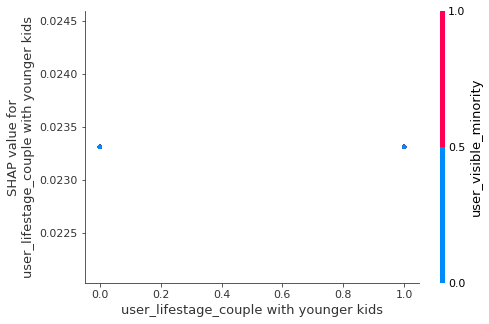

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


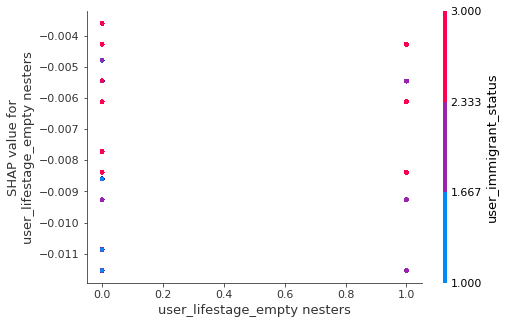

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


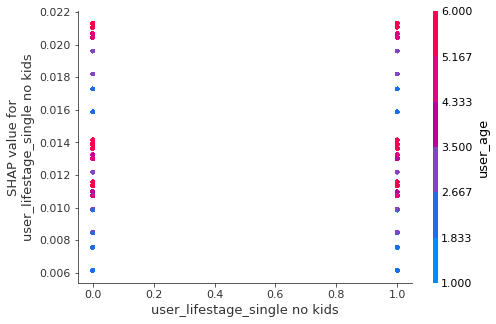

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


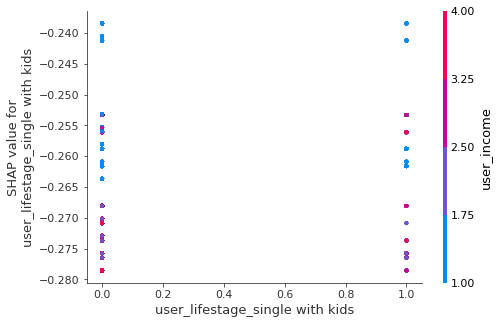

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


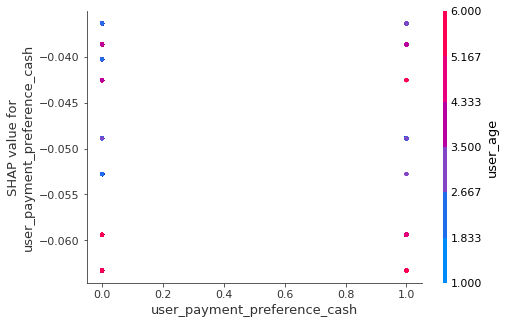

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


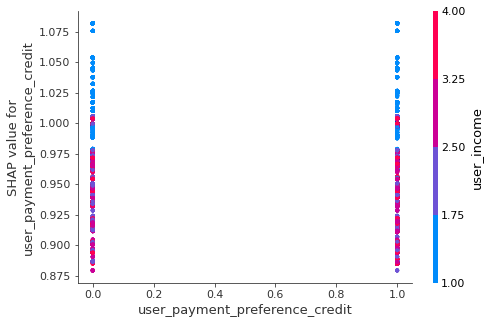

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


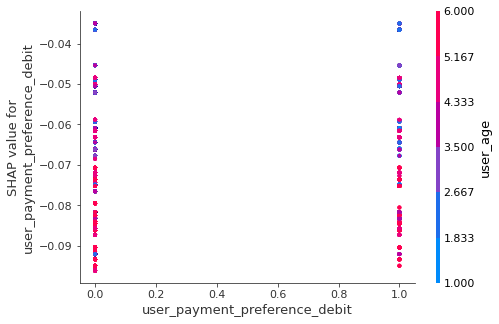

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


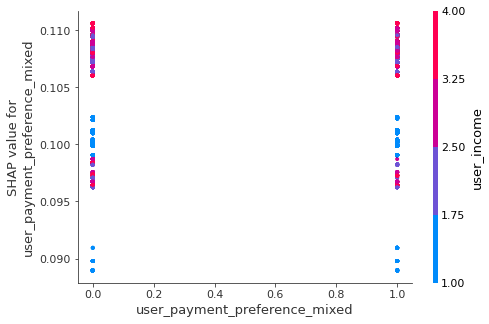

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


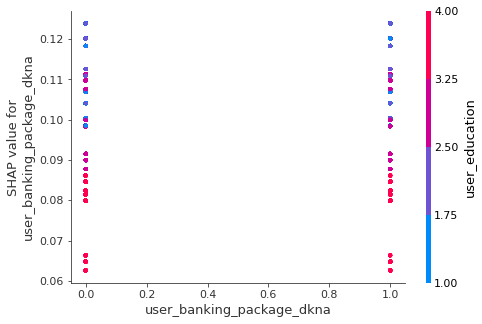

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


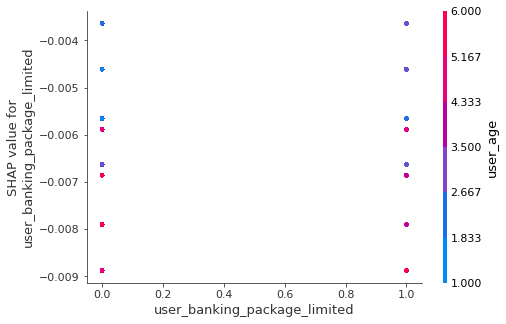

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


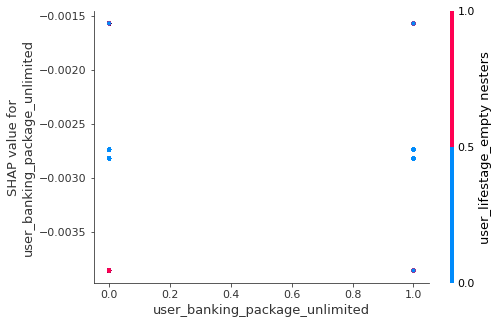

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


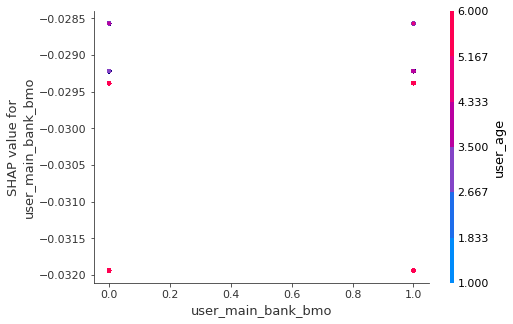

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


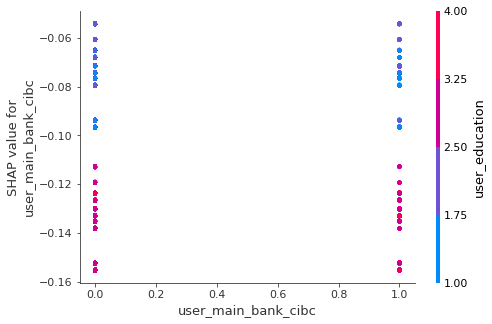

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


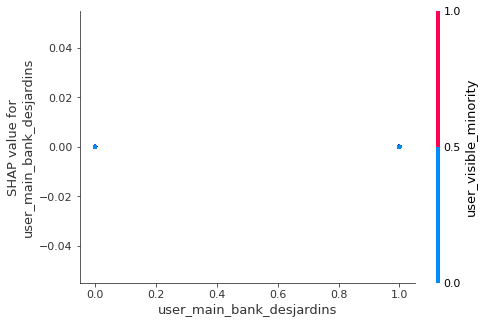

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


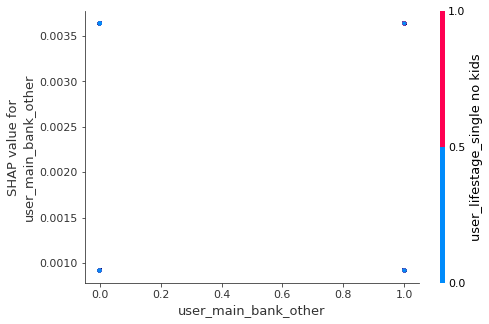

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


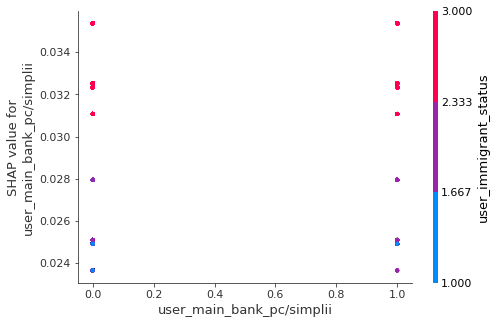

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


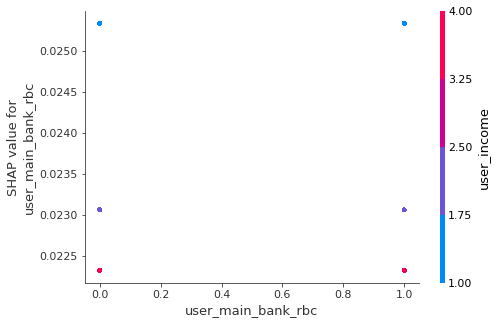

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


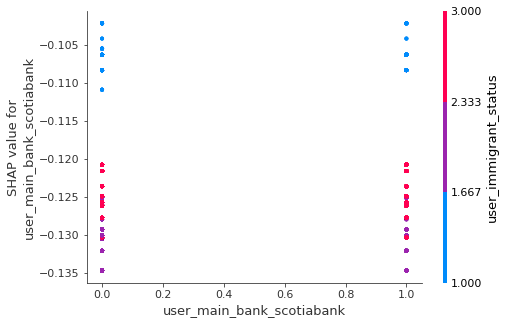

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


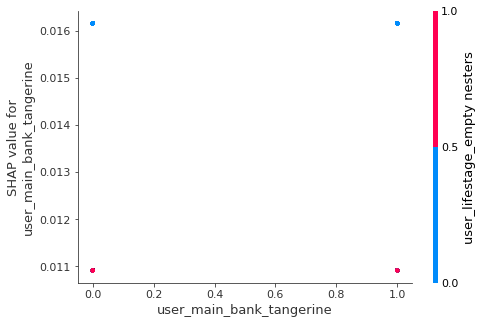

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


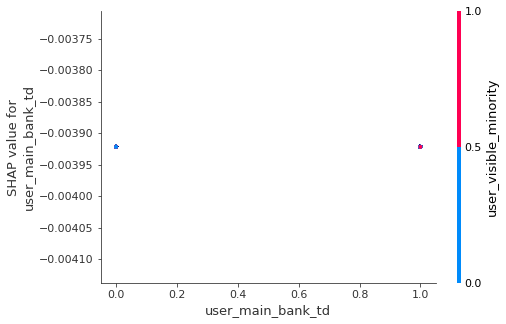

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


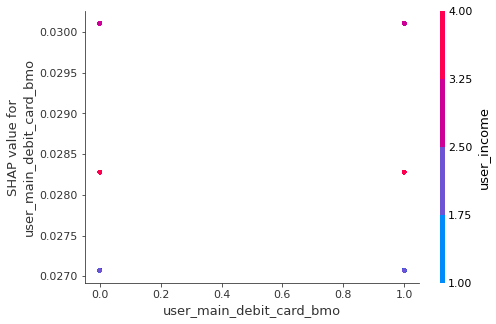

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


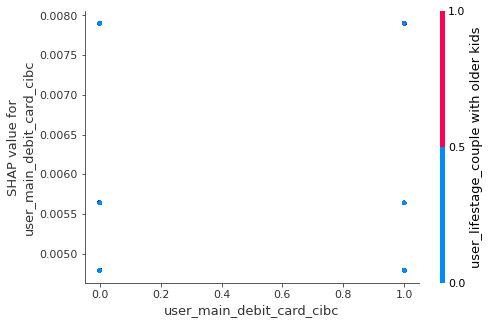

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


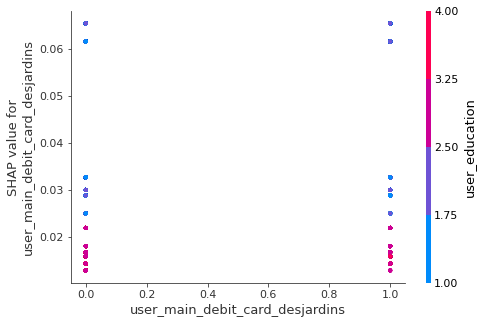

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


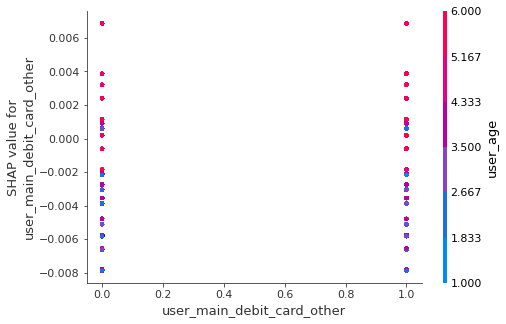

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


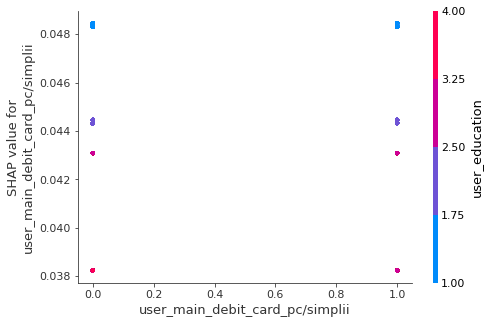

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


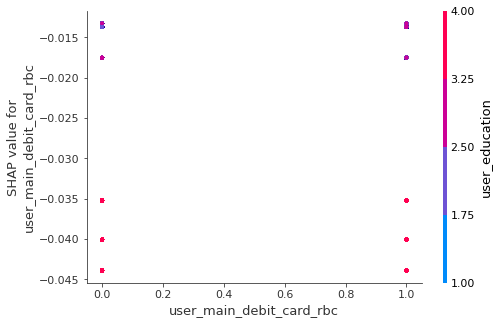

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


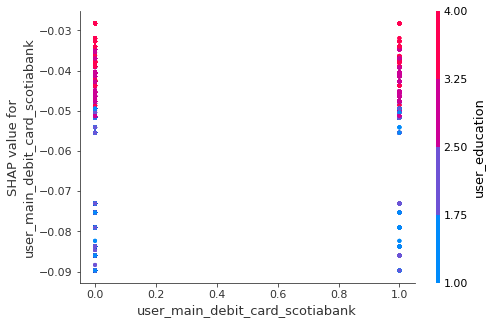

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


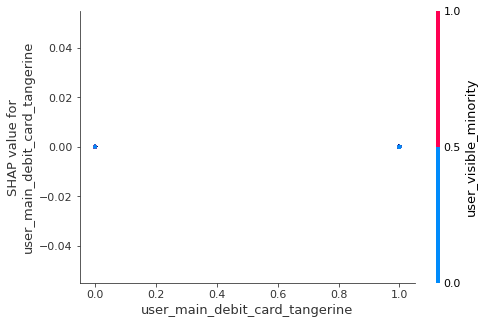

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


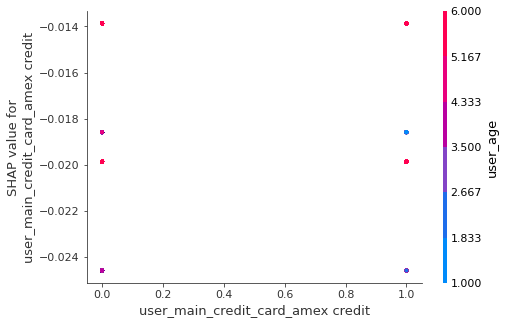

invalid value encountered in true_divide
invalid value encountered in true_divide


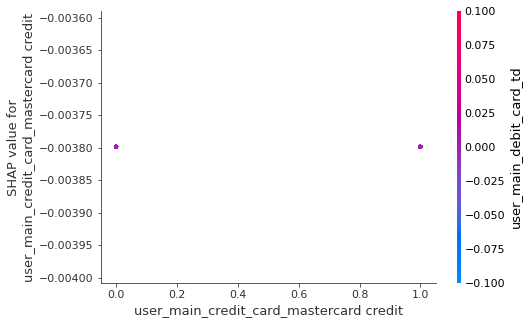

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


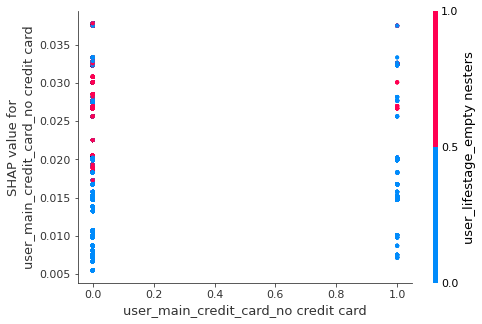

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


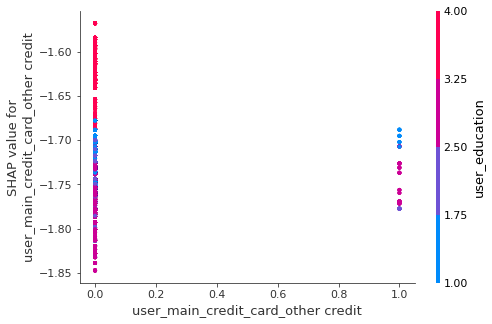

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


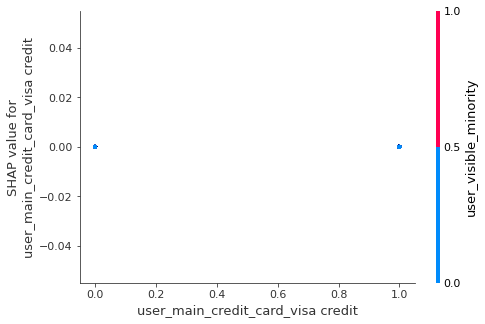

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


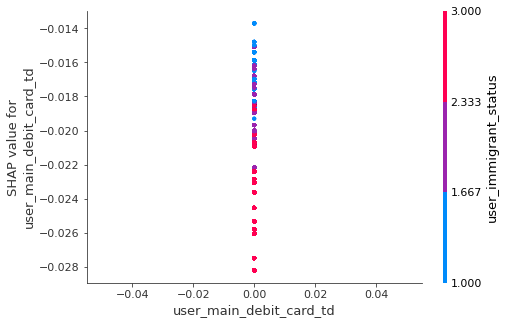

In [24]:
for name in X_encoded.columns:
    shap.dependence_plot(name, shap_values[0], X_encoded.values, display_features=X_encoded)